In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.path as mpath
from matplotlib import rc
import matplotlib.pyplot as plt
import netCDF4 as nc 
import pandas as pd 
import xarray as xr
from xgcm import Grid
from os.path import join,expanduser
import ecco_v4_py as ecco
import seaborn as sns
import tensorflow as tf
import scipy.io
import time
import warnings
import matplotlib.colors as colors
import dask
import statsmodels.api as sm
from pyDOE import *
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.interpolate import interpn
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator
from sklearn.metrics import r2_score
import plotly.express as px

np.random.seed(4321)
tf.set_random_seed(4321)

/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages

In [2]:
# LOADING IN ECCO GRID + DATA

grid_path = '/projects/SOCCOM/datasets/ecco/Version4/Release4/nctiles_grid/'
ecco_grid = xr.open_dataset(grid_path+'ECCO-GRID.nc')

ds = xr.Dataset()
tags = ['THETA','SALT','EVEL', 'NVEL', 'WVELMASS', 'PHIHYD', 'RHOAnoma']

for i in range(1992,1993):
    for tag in tags:
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            data_path = '/projects/SOCCOM/datasets/ecco/Version4/Release4/interp_monthly/'+tag+'/' + str(i) +'/'+tag+'_' + str(i) + '_??.nc'
            dsnow = xr.open_mfdataset(data_path,chunks="auto",data_vars='minimal',coords='minimal', compat='override') 
            ds = xr.merge([ds, dsnow])
    
# make the XGCM object
xgcm_grid = ecco.get_llc_grid(ecco_grid)

# interpolate w velocity onto regular grid
WVELMASS_interp = xgcm_grid.interp(ds.WVELMASS, "Z", boundary='fill')
# adjusting the pressure anomaly to not be 1/rho
PHI = ds.PHIHYD*(ds.RHOAnoma+1029) # rho_const = 1029
# creating land mask
maskC = ds.SALT.where(np.logical_or(ds.SALT.isnull(), ds.SALT==0),1).isel(time=0)

# get the grid
ds = xr.merge([ds, WVELMASS_interp.rename('WVELMASS_interp'), PHI.rename('PHI'), maskC.rename('maskC')],compat='override')

In [3]:
# DATA PREPROCESSING (with Navier Stokes normalization)
# gets the index of the array for each dimension before flattening
def using_multiindex(A, columns):
    shape = A.shape
    index = pd.MultiIndex.from_product([range(s) for s in shape], names=columns)
    df = pd.DataFrame({'A': A.flatten()}, index=index).reset_index()
    return df

def make_nninputs(ds, tags, time_ind, depth_ind, j_ind, i_ind, N_train):
    # ds is the main ecco data array
    # tags is a list of strings corresponding to the input variables i.e. ['THETA','SALT', ...]
        # first tagged variable must be in 4d, others can be in 3d
    # tile_ind, depth_ind, j_ind, and i_ind are tuples for subsetted data
    # N_train is a number between 0 and 100 describing percentage of data sampled
    # returns inputs_nn which is an array of all the training data of size N points x [time, depth, lat, lon, tags...]
    # returns coords_nn which is an array of all the training data coordinates of size N points x [time, k, j, i]
    
    subset_template = ds[tags[0]].where(ds.maskC>0).isel(time=slice(*time_ind),k=slice(*depth_ind),j=slice(*j_ind),i=slice(*i_ind))
    # assuming that only one tile is chosen (OTHERWISE WILL HAVE TO CHANGE CODE)
    inputs_nn = using_multiindex(subset_template.squeeze().values, ['time', 'k', 'j', 'i']) # makes array N x 5 [time, k, j, i, *first tag*]
    inputs_nn = inputs_nn.to_numpy()
    if N_train < 100: # for validation data no need to scramble coordinates
        N_train = int(N_train/100*len(inputs_nn[:,0]))
        train_idx = np.random.choice(len(inputs_nn[:,0]), N_train, replace=False) # Generate a random sample from np.arange(N*T) of size N_train
    else: 
        train_idx = range(len(inputs_nn[:,0]))
    inputs_nn = inputs_nn[train_idx,:] # subsample the training data
    coords_nn = inputs_nn[:,0:4].astype(int) # makes the time,kji indices integers for future use
    inputs_nn = inputs_nn[:,4:] # trim array by cutting out coordinates
    
    for tag in tags:
        throwaway = ds[tag].where(ds.maskC).isel(time=slice(*time_ind),k=slice(*depth_ind),j=slice(*j_ind),i=slice(*i_ind)).squeeze().values.flatten()[train_idx,np.newaxis]
        inputs_nn = np.concatenate((inputs_nn, throwaway),axis=1)

    inputs_nn = inputs_nn[:,1:] # need to remove the first dummy variable
    
    # assuming that only one tile is chosen (OTHERWISE WILL HAVE TO CHANGE CODE)

    a=6371*1000 # radius of the earth in meters
    throwaway = np.radians(ds.longitude.isel(i=slice(*i_ind)))*a*np.cos(np.radians(ds.latitude.isel(j=slice(*j_ind))))
    throwaway = throwaway.values
    throwaway2 = throwaway[coords_nn[:,3],coords_nn[:,2]][:,np.newaxis]  
    inputs_nn = np.concatenate((throwaway2,inputs_nn),axis=1)
    throwaway = np.radians(ds.latitude.isel(j=slice(*j_ind)))*a*np.cos(0*np.radians(ds.longitude.isel(i=slice(*i_ind)))) # these are the Y positions lat*r
    throwaway = throwaway.values
    throwaway2 = throwaway[coords_nn[:,2],coords_nn[:,3]][:,np.newaxis]
    inputs_nn = np.concatenate((throwaway2,inputs_nn),axis=1)
    throwaway = ds.Z.isel(k=slice(*depth_ind)).values[coords_nn[:,1],np.newaxis] # get depth coordinates
    inputs_nn = np.concatenate((throwaway,inputs_nn),axis=1)
    throwaway = ds.timestep.isel(time=slice(*time_ind)).values[coords_nn[:,0],np.newaxis]*3600
    inputs_nn = np.concatenate((throwaway,inputs_nn),axis=1)

    lb_nn = np.nanmin(inputs_nn,axis=0)
    char_nn = (np.nanmax(inputs_nn,axis=0)-lb_nn)/2
    inputs_nn = (inputs_nn-lb_nn)/char_nn - 1
    
    # get rid of the nans after calculating mean + std
    inputs_nn[np.isnan(inputs_nn)] = 0
                                   
    return subset_template, inputs_nn, coords_nn, char_nn, lb_nn

def split_nninputs(inputs_nn, coords_nn):
    
    # splits a full training dataset into a 20% validation and 80% training portion
    
    N_train = int(0.2*len(inputs_nn[:,0])) # 20% data used for validation
    val_idx = np.random.choice(len(inputs_nn[:,0]), N_train, replace=False)
    # select out 20% of training data for validation
    inputs_val = inputs_nn[val_idx,:]
    coords_val = coords_nn[val_idx,:]
    # leave remaining 80% of training data for training
    inputs_train = np.delete(inputs_nn, val_idx, axis=0)
    coords_train = np.delete(coords_nn, val_idx, axis=0)
    
    return inputs_val, coords_val, inputs_train, coords_train

In [3]:
tags = ['THETA','SALT','EVEL', 'NVEL','WVELMASS_interp','PHI','RHOAnoma']

time_ind = (0,12)
k_ind = (20,37)
j_ind = (40,70)
i_ind = (40,70)

nIter=1000 # Adams optimizer, L-BFGS has max 15000 iterations
# gamma=0.1 # how much we believe equations compared to data

In [4]:
class PhysicsInformedNN:
    # Initialize the class
    
    def __init__(self, inputs_nn, char_nn, lb_nn, col_nn, val_nn, layers, f_nn, gamma):
        
        # inputs_nn are the normalized training data
        # char_nn are the characteristic scales of the unnormalized training data
        # lb_nn are the minima of the unnormalized training data
        # col_nn are the normalized collocation points
        # layers are the structure of the PINN
        # f_nn is the coriolis constant for the collocation points
        # gamma is a hyperparameter whose value ranges from 0 to 1 to weigh the overall loss: (1-gamma)*data_loss + gamma*eq_loss, must be float (0.0 instead of 0)

        # Coriolis constants
        self.f_nn = f_nn
        
        # equation weighting
        self.gamma = tf.constant(gamma)
        
        X = inputs_nn[:,0:4]
                
        self.X = X
        
        self.char_nn = char_nn
        self.lb_nn = lb_nn
        
        # Training points
        
        self.t = inputs_nn[:,0:1]
        self.k = inputs_nn[:,1:2]
        self.j = inputs_nn[:,2:3]
        self.i = inputs_nn[:,3:4]
    
        self.T = inputs_nn[:,4:5]
        self.S = inputs_nn[:,5:6]
        self.u = inputs_nn[:,6:7]
        self.v = inputs_nn[:,7:8]
        self.w = inputs_nn[:,8:9]
        self.p = inputs_nn[:,9:10]
        self.rho = inputs_nn[:,10:11]
        
        # Collocation points
        
        self.t_c = col_nn[:,0:1]
        self.k_c = col_nn[:,1:2]
        self.j_c = col_nn[:,2:3]
        self.i_c = col_nn[:,3:4]
        
        # Validation points
        
        self.t_v = val_nn[:,0:1]
        self.k_v = val_nn[:,1:2]
        self.j_v = val_nn[:,2:3]
        self.i_v = val_nn[:,3:4]
        
        self.T_v = val_nn[:,4:5]
        self.S_v = val_nn[:,5:6]
        self.u_v = val_nn[:,6:7]
        self.v_v = val_nn[:,7:8]
        self.w_v = val_nn[:,8:9]
        self.p_v = val_nn[:,9:10]
        self.rho_v = val_nn[:,10:11]
        
        self.layers = layers
        
        # Counter for the reported NS terms
        self.counter = 0
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # training point tf placeholders
        self.i_tf = tf.placeholder(tf.float32, shape=[None, self.i.shape[1]])
        self.j_tf = tf.placeholder(tf.float32, shape=[None, self.j.shape[1]])
        self.k_tf = tf.placeholder(tf.float32, shape=[None, self.k.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        
        self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.T_tf = tf.placeholder(tf.float32, shape=[None, self.T.shape[1]])

        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]]) 
        self.w_tf = tf.placeholder(tf.float32, shape=[None, self.w.shape[1]])
        self.p_tf = tf.placeholder(tf.float32, shape=[None, self.p.shape[1]])
        self.rho_tf = tf.placeholder(tf.float32, shape=[None, self.rho.shape[1]])
        
        # collocation point tf placeholders
        self.i_ctf = tf.placeholder(tf.float32, shape=[None, self.i_c.shape[1]])
        self.j_ctf = tf.placeholder(tf.float32, shape=[None, self.j_c.shape[1]])
        self.k_ctf = tf.placeholder(tf.float32, shape=[None, self.k_c.shape[1]])
        self.t_ctf = tf.placeholder(tf.float32, shape=[None, self.t_c.shape[1]])
        
        # validation tf placeholders
        self.i_vtf = tf.placeholder(tf.float32, shape=[None, self.i_v.shape[1]])
        self.j_vtf = tf.placeholder(tf.float32, shape=[None, self.j_v.shape[1]])
        self.k_vtf = tf.placeholder(tf.float32, shape=[None, self.k_v.shape[1]])
        self.t_vtf = tf.placeholder(tf.float32, shape=[None, self.t_v.shape[1]])
        
        self.S_vtf = tf.placeholder(tf.float32, shape=[None, self.S_v.shape[1]])
        self.T_vtf = tf.placeholder(tf.float32, shape=[None, self.T_v.shape[1]])
        self.u_vtf = tf.placeholder(tf.float32, shape=[None, self.u_v.shape[1]])
        self.v_vtf = tf.placeholder(tf.float32, shape=[None, self.v_v.shape[1]]) 
        self.w_vtf = tf.placeholder(tf.float32, shape=[None, self.w_v.shape[1]])
        self.p_vtf = tf.placeholder(tf.float32, shape=[None, self.p_v.shape[1]])
        self.rho_vtf = tf.placeholder(tf.float32, shape=[None, self.rho_v.shape[1]])
        
        # diffusion placeholders
        # self.Kz = tf.Variable(initial_value=tf.random.normal(shape=self.i_c.shape,mean=1e-5,stddev=1e-6), dtype=tf.float32)
        # self.Ky = tf.Variable(initial_value=tf.random.normal(shape=self.i_c.shape,mean=1e3,stddev=10), dtype=tf.float32)
        # self.Kx = tf.Variable(initial_value=tf.random.normal(shape=self.i_c.shape,mean=1e3,stddev=10), dtype=tf.float32)
        self.Kz = tf.Variable([1e-5], dtype=tf.float32)
        self.Ky = tf.Variable([1e3], dtype=tf.float32)
        self.Kx = tf.Variable([1e3], dtype=tf.float32)
        
        # unconstrained w placeholder
        # self.w_test = tf.Variable(initial_value=tf.zeros_like(self.i_c,dtype=tf.float32), std_dev=1e-5)
        # self.w_test = tf.Variable(initial_value=tf.random.normal(shape=self.i_c.shape,mean=0,stddev=10e-6),dtype=tf.float32)
        

        # training points
        self.u_pred, self.v_pred, self.w_pred, self.p_pred, self.rho_pred, self.T_pred, self.S_pred = self.net_NS(self.t_tf, self.k_tf, self.j_tf, self.i_tf)

        # validation points
        self.u_val_pred, self.v_val_pred, self.w_val_pred, self.p_val_pred, self.rho_val_pred, self.T_val_pred, self.S_val_pred = self.net_NS(self.t_vtf, self.k_vtf, self.j_vtf, self.i_vtf)

        # collocation points
        self.fcont, self.fz_pred, self.fv_pred, self.fu_pred, self.fT_pred, self.fS_pred, self.u_t, self.uu_x, self.vu_y, self.wu_z, self.fv, self.p_x, self.u_predictions = self.net_f_NS(self.t_ctf, self.k_ctf, self.j_ctf, self.i_ctf)
        
        # losses
        
        self.fT_pred = tf.reduce_mean(tf.square(self.fT_pred))
        self.fS_pred = tf.reduce_mean(tf.square(self.fS_pred)) 
        
        self.diffloss = tf.math.maximum(-1*self.Kx,0) + tf.math.maximum(-1*self.Ky,0) + tf.math.maximum(-1*self.Kz,0)
        
        self.eqloss = tf.reduce_mean(tf.square(self.fcont)) + \
                    tf.reduce_mean(tf.square(self.fz_pred)) + \
                    tf.reduce_mean(tf.square(self.fv_pred)) + \
                    tf.reduce_mean(tf.square(self.fu_pred)) #+ \
                    # tf.reduce_mean(tf.square(self.fT_pred)) + \
                    # tf.reduce_mean(tf.square(self.fS_pred)) 

        self.dataloss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.v_tf - self.v_pred)) + \
                    tf.reduce_mean(tf.square(self.p_tf - self.p_pred)) + \
                    tf.reduce_mean(tf.square(self.rho_tf - self.rho_pred)) + \
                    tf.reduce_mean(tf.square(self.T_tf - self.T_pred)) + \
                    tf.reduce_mean(tf.square(self.S_tf - self.S_pred)) + \
                    tf.reduce_mean(tf.square(self.w_tf - self.w_pred))
        
        self.valloss = tf.reduce_mean(tf.square(self.u_vtf - self.u_val_pred)) + \
                    tf.reduce_mean(tf.square(self.v_vtf - self.v_val_pred)) + \
                    tf.reduce_mean(tf.square(self.p_vtf - self.p_val_pred)) + \
                    tf.reduce_mean(tf.square(self.rho_vtf - self.rho_val_pred)) + \
                    tf.reduce_mean(tf.square(self.T_vtf - self.T_val_pred)) + \
                    tf.reduce_mean(tf.square(self.S_vtf - self.S_val_pred)) + \
                    tf.reduce_mean(tf.square(self.w_vtf - self.w_val_pred))
        
        # self.wloss = tf.reduce_mean(1.0 - tf.math.exp(-tf.square(self.w_pred)/0.001))

        self.loss = (1-self.gamma)*self.dataloss + self.gamma*(self.eqloss) #+ self.diffloss
    
        # saved losses
        
        self.losses = []
        self.eq_losses = []
        self.data_losses = []
        self.val_losses = []
        self.fT_pred_losses = []
        self.fS_pred_losses = []
        self.fu_pred_losses = []
        self.u_t_losses = []
        self.uu_x_losses = []
        self.vu_y_losses = []
        self.wu_z_losses = []
        self.fv_losses = []
        self.p_x_losses = []
        self.u_pred_losses = []
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 15000,  # original maxiter is 50000
                                                                           'maxfun': 50000,
                                                                           'maxcor': 25,
                                                                           'maxls': 25,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss) 
        
        init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        self.sess.run(init)

    def initialize_NN(self, layers): 
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        # initializer = tf.variance_scaling_initializer(scale=1.0, mode='fan_in')
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
        # return tf.Variable(initializer(shape=(in_dim, out_dim)), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            # H = tf.keras.activations.selu(tf.add(tf.matmul(H, W), b))
            # H = tf.tanh(tf.add(tf.matmul(H, W), b))
            H = tf.sin(tf.add(tf.matmul(H, W), b)) # prediction ability not as good
            # H = tf.nn.relu(tf.add(tf.matmul(H, W), b)) # prediction ability not as good
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b) # linear activation function for the last layer
        return Y
        
    def net_f_NS(self, t, k, j, i):
        
        Kx = self.Kx
        Ky = self.Ky
        Kz = self.Kz
        # w_full = self.w_test
        # getting equation losses on collocation points
        
        with tf.GradientTape(persistent=True) as tape2:
            # Watch the input variables
            tape2.watch(t)
            tape2.watch(k)
            tape2.watch(j)
            tape2.watch(i)
        
            with tf.GradientTape(persistent=True) as tape:
                # Watch the input variables
                tape.watch(t)
                tape.watch(k)
                tape.watch(j)
                tape.watch(i)

                uvwp = self.neural_net(tf.concat([t, k, j, i],1),self.weights,self.biases)
                u_hat = uvwp[:,0:1]
                v_hat = uvwp[:,1:2]
                w_hat = uvwp[:,2:3]
                p_hat = uvwp[:,3:4]
                rho_hat = uvwp[:,4:5]
                T_hat = uvwp[:,5:6]
                S_hat = uvwp[:,6:7]
                
            u_t, u_z, u_y, u_x = tape.gradient(u_hat, [t, k, j, i])
            v_t, v_z, v_y, v_x = tape.gradient(v_hat, [t, k, j, i])
            w_z = tape.gradient(w_hat, k)
            p_z, p_y, p_x = tape.gradient(p_hat, [k, j, i])
            T_t, T_z, T_y, T_x = tape.gradient(T_hat, [t, k, j, i])
            S_t, S_z, S_y, S_x = tape.gradient(S_hat, [t, k, j, i])
        
        char_nn = self.char_nn
        lb_nn = self.lb_nn

        f = self.f_nn
       
        T_zz = tape2.gradient(T_z, k)
        T_yy = tape2.gradient(T_y, j)
        T_xx = tape2.gradient(T_x, i)
        S_zz = tape2.gradient(S_z, k)
        S_yy = tape2.gradient(S_y, j)
        S_xx = tape2.gradient(S_x, i)
        
        u_full = (u_hat+1)*char_nn[6]+lb_nn[6]
        v_full = (v_hat+1)*char_nn[7]+lb_nn[7]
        w_full = (w_hat+1)*char_nn[8]+lb_nn[8]
        # w_full = w_hat
        rho_full = (rho_hat+1)*char_nn[10]+lb_nn[10]
    
        # continuity equation
        fcont = char_nn[1]/char_nn[8]*(char_nn[6]/char_nn[3]*u_x + char_nn[7]/char_nn[2]*v_y + char_nn[8]/char_nn[1]*w_z)
        # fcont = char_nn[3]/char_nn[6]*(char_nn[6]/char_nn[3]*u_x + char_nn[7]/char_nn[2]*v_y + 1/char_nn[1]*w_z)
        
        # hydrostatic balance
        fz = char_nn[1]/char_nn[9]*(-char_nn[9]/char_nn[1]*p_z - rho_full*9.81)
        
        # zonal momentum 
        fu = 1029*char_nn[3]/char_nn[9]*(char_nn[6]/char_nn[0]*u_t + char_nn[6]/char_nn[3]*u_full*u_x + char_nn[6]/char_nn[2]*v_full*u_y + char_nn[6]/char_nn[1]*w_full*u_z - f*v_full + char_nn[9]/char_nn[3]/1029*p_x)

        # meridional momentum
        fv = 1029*char_nn[2]/char_nn[9]*(char_nn[7]/char_nn[0]*v_t + char_nn[7]/char_nn[3]*u_full*v_x + char_nn[7]/char_nn[2]*v_full*v_y + char_nn[7]/char_nn[1]*w_full*v_z + f*u_full + char_nn[9]/char_nn[2]/1029*p_y)

        # temperature conservation
        fT = char_nn[3]/char_nn[4]*(char_nn[4]/char_nn[0]*T_t + char_nn[4]/char_nn[3]*u_full*T_x + char_nn[4]/char_nn[2]*v_full*T_y + char_nn[4]/char_nn[1]*w_full*T_z - Kx*char_nn[4]/char_nn[3]**2*T_xx - Ky*char_nn[4]/char_nn[2]**2*T_yy - Kz*char_nn[4]/char_nn[1]**2*T_zz) 
        
        # salinity conservation
        fS = char_nn[3]/char_nn[5]*(char_nn[5]/char_nn[0]*T_t + char_nn[5]/char_nn[3]*u_full*S_x + char_nn[5]/char_nn[2]*v_full*S_y + char_nn[5]/char_nn[1]*w_full*S_z - Kx*char_nn[5]/char_nn[3]**2*S_xx - Ky*char_nn[5]/char_nn[2]**2*S_yy - Kz*char_nn[5]/char_nn[1]**2*S_zz) 
        
        del tape, tape2
        
        return fcont, fz, fv, fu, fT, fS, 1029*char_nn[3]/char_nn[9]*(char_nn[6]/char_nn[0]*u_t), 1029*char_nn[3]/char_nn[9]*(char_nn[6]/char_nn[3]*u_full*u_x), 1029*char_nn[3]/char_nn[9]*(char_nn[6]/char_nn[2]*v_full*u_y), 1029*char_nn[3]/char_nn[9]*(char_nn[6]/char_nn[1]*w_full*u_z), 1029*char_nn[3]/char_nn[9]*(-f*v_full), 1029*char_nn[3]/char_nn[9]*(char_nn[9]/char_nn[3]/1029*p_x), u_hat
    
    def net_NS(self, t, k, j, i):
        
        # getting data loss on training points
        
        uvwp = self.neural_net(tf.concat([t, k, j, i], 1), self.weights, self.biases)
        u_hat = uvwp[:,0:1]
        v_hat = uvwp[:,1:2]
        w_hat = uvwp[:,2:3]
        p_hat = uvwp[:,3:4]
        rho_hat = uvwp[:,4:5]
        T_hat = uvwp[:,5:6]
        S_hat = uvwp[:,6:7]
        
        return u_hat, v_hat, w_hat, p_hat, rho_hat, T_hat, S_hat

    def callback(self, loss, dataloss, eqloss, valloss, fT_pred, fS_pred, fu_pred, u_t, uu_x, vu_y, wu_z, fv, p_x, u_predictions, Kz, Ky, Kx):
    # def callback(self, loss, dataloss, eqloss, fu_pred):
        
        callback_val = tf.keras.callbacks.EarlyStopping(monitor='valloss', patience=10, mode='auto',baseline=None)
        
        if self.counter % 100 == 0:
            # print('L-BFGS-B It: %d, Loss: %.3e, Data loss: %.3e, Eq loss: %.3e, Val loss: %.3e, T loss: %.3e, S loss: %.3e' % (self.counter, loss, dataloss, eqloss, valloss, fT_pred, fS_pred))
            self.losses.append(loss)
            self.eq_losses.append(eqloss)
            self.data_losses.append(dataloss)
            self.val_losses.append(valloss)
            self.fT_pred_losses.append(fT_pred)
            self.fS_pred_losses.append(fS_pred)
            self.fu_pred_losses.append(fu_pred)
            self.u_t_losses.append(u_t)
            self.uu_x_losses.append(uu_x)
            self.vu_y_losses.append(vu_y)
            self.wu_z_losses.append(wu_z)
            self.fv_losses.append(fv)
            self.p_x_losses.append(p_x)
            self.u_pred_losses.append(u_predictions)
        
        self.counter = self.counter + 1
        return callback_val
 
    def train(self, nIter): 

        tf_dict = {self.i_tf: self.i, self.j_tf: self.j, self.k_tf: self.k, self.t_tf: self.t, self.S_tf: self.S, self.T_tf: self.T, self.u_tf: self.u, self.v_tf: self.v, self.w_tf: self.w, self.p_tf: self.p, self.rho_tf: self.rho,\
                   self.i_ctf: self.i_c, self.j_ctf: self.j_c, self.k_ctf: self.k_c, self.t_ctf: self.t_c,\
                  self.i_vtf: self.i_v, self.j_vtf: self.j_v, self.k_vtf: self.k_v, self.t_vtf: self.t_v, self.S_vtf: self.S_v, self.T_vtf: self.T_v, self.u_vtf: self.u_v, self.v_vtf: self.v_v, self.w_vtf: self.w_v, self.p_vtf: self.p_v, self.rho_vtf: self.rho_v}
        
        start_time = time.time()
        
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 100 == 0:
                
                loss_value = self.sess.run(self.loss, tf_dict)
                data_value = self.sess.run(self.dataloss, tf_dict)
                eq_value = self.sess.run(self.eqloss, tf_dict)
                val_value = self.sess.run(self.valloss, tf_dict)
                # tracer concentration values
                fT_value = self.sess.run(self.fT_pred, tf_dict)
                fS_value = self.sess.run(self.fS_pred, tf_dict)
                # fT_value = np.mean(np.square(self.sess.run(self.fT_pred,tf_dict)))
                # fS_value = np.mean(np.square(self.sess.run(self.fS_pred,tf_dict)))
                # Kz_value = self.sess.run(self.Kz, tf_dict)
                # Ky_value = self.sess.run(self.Ky, tf_dict)
                # Kx_value = self.sess.run(self.Kx, tf_dict)
                # w_value = self.sess.run(self.w_diff, tf_dict)
                fS_value = self.sess.run(self.fS_pred, tf_dict)
                elapsed = time.time() - start_time
                
                # print('Adam It: %d, Total loss: %.3e, Data loss: %.3e, Eq loss: %.3e, Val loss: %.3e, T loss: %.3e, S loss: %.3e, Time: %.2f' % 
                      # (it, loss_value, data_value, eq_value, val_value, fT_value, fS_value, elapsed))
        
                # extra values
                fu_value = self.sess.run(self.fu_pred,tf_dict)
                u_t_value = self.sess.run(self.u_t,tf_dict)
                uu_x_value = self.sess.run(self.uu_x,tf_dict)
                vu_y_value = self.sess.run(self.vu_y,tf_dict)
                wu_z_value = self.sess.run(self.wu_z,tf_dict)
                fv_value = self.sess.run(self.fv,tf_dict)
                p_x_value = self.sess.run(self.p_x,tf_dict)
                u_predictions_value = self.sess.run(self.u_predictions,tf_dict)

                self.losses.append(loss_value)
                self.eq_losses.append(eq_value)
                self.data_losses.append(data_value)
                self.val_losses.append(val_value)
                self.fT_pred_losses.append(fT_value)
                self.fS_pred_losses.append(fS_value)
                self.fu_pred_losses.append(fu_value)
                self.u_t_losses.append(u_t_value)
                self.uu_x_losses.append(uu_x_value)
                self.vu_y_losses.append(vu_y_value)
                self.wu_z_losses.append(wu_z_value)
                self.fv_losses.append(fv_value)
                self.p_x_losses.append(p_x_value) 
                self.u_pred_losses.append(u_predictions_value)
                
        self.counter = nIter
                
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                # fetches = [self.loss, self.dataloss, self.eqloss, self.fu_pred],
                                fetches = [self.loss, self.dataloss, self.eqloss, self.valloss, self.fT_pred, self.fS_pred, self.fu_pred, self.u_t, self.uu_x, self.vu_y, self.wu_z, self.fv, self.p_x, self.u_predictions, self.Kz, self.Ky, self.Kx],
#                                 loss_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, mode='auto',verbose=2,baseline=None))
                                loss_callback = self.callback)
        
        # return self.losses, self.eq_losses, self.data_losses, self.fu_pred_losses
        return self.losses, self.eq_losses, self.data_losses, self.val_losses, self.fT_pred_losses, self.fS_pred_losses, self.fu_pred_losses, self.u_t_losses, self.uu_x_losses, self.vu_y_losses, self.wu_z_losses, self.fv_losses, self.p_x_losses, self.u_pred_losses
    
    def predict(self, t_star, k_star, j_star, i_star):
        
        tf_dict = {self.i_tf: i_star, self.j_tf: j_star, self.k_tf: k_star, self.t_tf: t_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        w_star = self.sess.run(self.w_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)
        rho_star = self.sess.run(self.rho_pred, tf_dict)
        T_star = self.sess.run(self.T_pred, tf_dict)
        S_star = self.sess.run(self.S_pred, tf_dict)
        Kx_star = self.sess.run(self.Kx, tf_dict)
        Ky_star = self.sess.run(self.Ky, tf_dict)
        Kz_star = self.sess.run(self.Kz, tf_dict)

        return u_star, v_star, w_star, p_star, rho_star, T_star, S_star, Kx_star, Ky_star, Kz_star

    def compute_gradients(self, t, k, j, i):
        
        # check that the automatic differentiation matches the numerical differentiation outside of the PINN
        
        tf_dict = {self.i_tf: i, self.j_tf: j, self.k_tf: k, self.t_tf: t}

        with tf.GradientTape(persistent=True) as tape:
            # Watch the input variables
            tape.watch(self.t_tf)
            tape.watch(self.k_tf)
            tape.watch(self.j_tf)
            tape.watch(self.i_tf)

            uvwp = self.neural_net(tf.concat([self.t_tf, self.k_tf, self.j_tf, self.i_tf], 1), self.weights, self.biases)
            u_hat = uvwp[:,0:1]
            v_hat = uvwp[:,1:2]
            w_hat = uvwp[:,2:3]
            p_hat = uvwp[:,3:4]
            rho_hat = uvwp[:,4:5]
            T_hat = uvwp[:,5:6]
            S_hat = uvwp[:,6:7]

        inputs = [self.t_tf, self.k_tf, self.j_tf, self.i_tf]

        # Compute the gradients 
        gradients = [self.sess.run(tape.gradient(u_hat, input_var),feed_dict=tf_dict) for input_var in inputs]

        # Clean up the tape
        del tape

        return gradients, self.sess.run(u_hat,feed_dict=tf_dict)
    
    def save_model(self, save_path):
        self.saver.save(self.sess, save_path)
        print('model saved!')

In [44]:
# ### RELOADING THE MODEL
# ckpt_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer100_run3.ckpt"
# array_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer100_run3.npz"

# loaded_data = np.load(array_file) # to load the arrays from the .npz file:

# inputs_train=loaded_data['inputs_train']
# char_train=loaded_data['char_train']
# lb_train=loaded_data['lb_train']
# col_train=loaded_data['col_train']

# layers=loaded_data['layers']

# f_col=loaded_data['f_col']
# inputs_val=loaded_data['inputs_val']
# coords_val=loaded_data['coords_val']

# inputs_test=loaded_data['inputs_test']
# coords_test = loaded_data['coords_test']
# char_test=loaded_data['char_test']
# lb_test=loaded_data['lb_test']

# data_losses=loaded_data['data_losses']
# eq_losses=loaded_data['eq_losses']
# val_losses=loaded_data['val_losses']
# losses=loaded_data['losses']

# tf.reset_default_graph()
# if __name__ == "__main__":  
#     model = PhysicsInformedNN(inputs_train, char_train, lb_train, col_train, inputs_val, layers, f_col, 0.1)
#     model.saver.restore(model.sess, ckpt_file)
#     print('model reloaded!')

INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer100_run3.ckpt
model reloaded!


In [6]:
### RELOADING THE MODEL
ckpt_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma20_run3.ckpt"
array_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma20_run3.npz"

loaded_data = np.load(array_file) # to load the arrays from the .npz file:

inputs_train=loaded_data['inputs_train']
char_train=loaded_data['char_train']
lb_train=loaded_data['lb_train']
col_train=loaded_data['col_train']

layers=loaded_data['layers']

f_col=loaded_data['f_col']
inputs_val=loaded_data['inputs_val']
coords_val=loaded_data['coords_val']

inputs_test=loaded_data['inputs_test']
coords_test = loaded_data['coords_test']
char_test=loaded_data['char_test']
lb_test=loaded_data['lb_test']

data_losses=loaded_data['data_losses']
eq_losses=loaded_data['eq_losses']
val_losses=loaded_data['val_losses']
losses=loaded_data['losses']

tf.reset_default_graph()
if __name__ == "__main__":  
    model = PhysicsInformedNN(inputs_train, char_train, lb_train, col_train, inputs_val, layers, f_col, 0.1)
    model.saver.restore(model.sess, ckpt_file)
    print('model reloaded!')

In [36]:
# data_losses_all = np.zeros((50,200))
# data_losses_all[0,:] = data_losses

# test = np.pad(data_losses, (0, 200-data_losses.size), 'constant', constant_values=(np.nan))
# test = test[np.newaxis,:]
# test = np.concatenate((test, test),axis=0)
# np.repeat(train_percent,5)[:,np.newaxis].shape
# data_losses_all = np.concatenate((np.repeat(train_percent,5)[:,np.newaxis],data_losses_all),axis=1)
data_losses_all

array([['5', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['5', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['5', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ...,
       ['100', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['100', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['100', '0.0', '0.0', ..., '0.0', '0.0', '0.0']], dtype='<U32')

In [10]:
### MODEL TESTING

if __name__ == "__main__": 
    
    t_test = inputs_test[:,0:1]
    z_test = inputs_test[:,1:2]
    y_test = inputs_test[:,2:3]
    x_test = inputs_test[:,3:4]
    T_test = inputs_test[:,4:5]
    S_test = inputs_test[:,5:6] 
    u_test = inputs_test[:,6:7]
    v_test = inputs_test[:,7:8]
    w_test = inputs_test[:,8:9]
    p_test = inputs_test[:,9:10]
    rho_test = inputs_test[:,10:11]
    
    # model prediction
    u_pred, v_pred, w_pred, p_pred, rho_pred, T_pred, S_pred, Kx_pred, Ky_pred, Kz_pred = model.predict(t_test, z_test, y_test, x_test)
    
# Relative error (from normalized quantities)
error_T = np.sum(np.square((T_test - T_pred)))/np.sum(np.square((T_test)))
error_S = np.sum(np.square((S_test - S_pred)))/np.sum(np.square((S_test)))
error_u = np.sum(np.square((u_test - u_pred)))/np.sum(np.square((u_test)))
error_v = np.sum(np.square((v_test - v_pred)))/np.sum(np.square((v_test)))
error_w = np.sum(np.square((w_test - w_pred)))/np.sum(np.square((w_test)))
error_p = np.sum(np.square((p_test - p_pred)))/np.sum(np.square((p_test)))
error_rho = np.sum(np.square((rho_test - rho_pred)))/np.sum(np.square((rho_test)))

# error_u = r2_score(u_test, u_pred)
# error_v = r2_score(v_test, v_pred)
# error_w = r2_score(w_test, w_pred)
# error_p = r2_score(p_test, p_pred)
# error_rho = r2_score(rho_test, rho_pred)
# error_T = r2_score(T_test, T_pred)
# error_S = r2_score(S_test, S_pred)

print('rel error u-hat: %e' % (error_u))    
print('rel error v-hat: %e' % (error_v))   
print('rel error w-hat: %e' % (error_w))  
print('rel error p-hat: %e' % (error_p)) 
print('rel error rho-hat: %e' % (error_rho))
print('rel error T-hat: %e' % (error_T)) 
print('rel error S-hat: %e' % (error_S))

rel error u-hat: 1.076464e+00
rel error v-hat: 1.490319e+00
rel error w-hat: 1.055361e+00
rel error p-hat: 8.036657e-01
rel error rho-hat: 1.999451e+00
rel error T-hat: 1.039145e+00
rel error S-hat: 1.036139e+00


In [7]:
# storing errors from model complexities

layer_widths = ['5','10','20','50','70','100']
for i in range(len(layer_widths)):
    for j in range(5):
        ckpt_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer"+layer_widths[i]+"_run"+str(j+1)+".ckpt"
        array_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer"+layer_widths[i]+"_run"+str(j+1)+".npz"
        loaded_data = np.load(array_file) # to load the arrays from the .npz file:
        
        inputs_train=loaded_data['inputs_train']
        char_train=loaded_data['char_train']
        lb_train=loaded_data['lb_train']
        col_train=loaded_data['col_train']
        inputs_val=loaded_data['inputs_val']
        layers=loaded_data['layers']
        f_col=loaded_data['f_col']
        inputs_test=loaded_data['inputs_test']

        tf.reset_default_graph()
        if __name__ == "__main__":  
            model = PhysicsInformedNN(inputs_train, char_train, lb_train, col_train, inputs_val, layers, f_col, 0.1)
            model.saver.restore(model.sess, ckpt_file)
            print('model reloaded!')
            
            t_test = inputs_test[:,0:1]
            z_test = inputs_test[:,1:2]
            y_test = inputs_test[:,2:3]
            x_test = inputs_test[:,3:4]
            T_test = inputs_test[:,4:5]
            S_test = inputs_test[:,5:6] 
            u_test = inputs_test[:,6:7]
            v_test = inputs_test[:,7:8]
            w_test = inputs_test[:,8:9]
            p_test = inputs_test[:,9:10]
            rho_test = inputs_test[:,10:11]

            # model prediction
            u_pred, v_pred, w_pred, p_pred, rho_pred, T_pred, S_pred, Kx_pred, Ky_pred, Kz_pred = model.predict(t_test, z_test, y_test, x_test)

        # Relative error (from normalized quantities)
        error_T = np.sum(np.square((T_test - T_pred)))/np.sum(np.square((T_test)))
        error_S = np.sum(np.square((S_test - S_pred)))/np.sum(np.square((S_test)))
        error_u = np.sum(np.square((u_test - u_pred)))/np.sum(np.square((u_test)))
        error_v = np.sum(np.square((v_test - v_pred)))/np.sum(np.square((v_test)))
        error_w = np.sum(np.square((w_test - w_pred)))/np.sum(np.square((w_test)))
        error_p = np.sum(np.square((p_test - p_pred)))/np.sum(np.square((p_test)))
        error_rho = np.sum(np.square((rho_test - rho_pred)))/np.sum(np.square((rho_test)))

        if i==0 and j==0:
            rel_errors = np.array([float(layer_widths[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            rel_errors = rel_errors[np.newaxis,:]
        else:
            throwaway = np.array([float(layer_widths[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            throwaway = throwaway[np.newaxis,:]
            rel_errors = np.concatenate((rel_errors,throwaway),axis=0)
            
        # Correlation error
        error_u = r2_score(u_test, u_pred)
        error_v = r2_score(v_test, v_pred)
        error_w = r2_score(w_test, w_pred)
        error_p = r2_score(p_test, p_pred)
        error_rho = r2_score(rho_test, rho_pred)
        error_T = r2_score(T_test, T_pred)
        error_S = r2_score(S_test, S_pred)
        
        if i==0 and j==0:
            r2_errors = np.array([float(layer_widths[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            r2_errors = r2_errors[np.newaxis,:]
        else:
            throwaway = np.array([float(layer_widths[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            throwaway = throwaway[np.newaxis,:]
            r2_errors = np.concatenate((r2_errors,throwaway),axis=0)

# save errors
error_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_errors.npz"
np.savez(error_file, r2_errors=r2_errors, rel_errors=rel_errors)

In [3]:
# storing errors from model depths

layer_depths = ['3','4','5','6','7']
for i in range(len(layer_depths)):
    for j in range(5):     
        if layer_depths[i] == '4':
            ckpt_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer50_run"+str(j+1)+".ckpt"
            array_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer50_run"+str(j+1)+".npz"
        else:
            ckpt_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-depth/latlon_k2037_j4070_i4070_gamma10_iter16000_layer50_deep"+layer_depths[i]+"_run"+str(j+1)+".ckpt"
            array_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-depth/latlon_k2037_j4070_i4070_gamma10_iter16000_layer50_deep"+layer_depths[i]+"_run"+str(j+1)+".npz"
        loaded_data = np.load(array_file) # to load the arrays from the .npz file:
        
        inputs_train=loaded_data['inputs_train']
        char_train=loaded_data['char_train']
        lb_train=loaded_data['lb_train']
        col_train=loaded_data['col_train']
        inputs_val=loaded_data['inputs_val']
        layers=loaded_data['layers']
        f_col=loaded_data['f_col']
        inputs_test=loaded_data['inputs_test']

        tf.reset_default_graph()
        if __name__ == "__main__":  
            model = PhysicsInformedNN(inputs_train, char_train, lb_train, col_train, inputs_val, layers, f_col, 0.1)
            model.saver.restore(model.sess, ckpt_file)
            print('model reloaded!')
            
            t_test = inputs_test[:,0:1]
            z_test = inputs_test[:,1:2]
            y_test = inputs_test[:,2:3]
            x_test = inputs_test[:,3:4]
            T_test = inputs_test[:,4:5]
            S_test = inputs_test[:,5:6] 
            u_test = inputs_test[:,6:7]
            v_test = inputs_test[:,7:8]
            w_test = inputs_test[:,8:9]
            p_test = inputs_test[:,9:10]
            rho_test = inputs_test[:,10:11]

            # model prediction
            u_pred, v_pred, w_pred, p_pred, rho_pred, T_pred, S_pred, Kx_pred, Ky_pred, Kz_pred = model.predict(t_test, z_test, y_test, x_test)

        # Relative error (from normalized quantities)
        error_T = np.sum(np.square((T_test - T_pred)))/np.sum(np.square((T_test)))
        error_S = np.sum(np.square((S_test - S_pred)))/np.sum(np.square((S_test)))
        error_u = np.sum(np.square((u_test - u_pred)))/np.sum(np.square((u_test)))
        error_v = np.sum(np.square((v_test - v_pred)))/np.sum(np.square((v_test)))
        error_w = np.sum(np.square((w_test - w_pred)))/np.sum(np.square((w_test)))
        error_p = np.sum(np.square((p_test - p_pred)))/np.sum(np.square((p_test)))
        error_rho = np.sum(np.square((rho_test - rho_pred)))/np.sum(np.square((rho_test)))

        if i==0 and j==0:
            rel_errors = np.array([float(layer_depths[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            rel_errors = rel_errors[np.newaxis,:]
        else:
            throwaway = np.array([float(layer_depths[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            throwaway = throwaway[np.newaxis,:]
            rel_errors = np.concatenate((rel_errors,throwaway),axis=0)
            
        # Correlation error
        error_u = r2_score(u_test, u_pred)
        error_v = r2_score(v_test, v_pred)
        error_w = r2_score(w_test, w_pred)
        error_p = r2_score(p_test, p_pred)
        error_rho = r2_score(rho_test, rho_pred)
        error_T = r2_score(T_test, T_pred)
        error_S = r2_score(S_test, S_pred)
        
        if i==0 and j==0:
            r2_errors = np.array([float(layer_depths[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            r2_errors = r2_errors[np.newaxis,:]
        else:
            throwaway = np.array([float(layer_depths[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            throwaway = throwaway[np.newaxis,:]
            r2_errors = np.concatenate((r2_errors,throwaway),axis=0)

# save errors
error_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-depth/latlon_k2037_j4070_i4070_gamma10_iter16000_errors.npz"
np.savez(error_file, r2_errors=r2_errors, rel_errors=rel_errors)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-depth/latlon_k2037_j4070_i4070_gamma10_iter16000_layer50_deep3_run1.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-depth/latlon_k2037_j4070_i4070_gamma10_iter16000_layer50_deep3_run2.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-depth/latlon_k2037_j4070_i4070_gamma10_iter16000_layer50_deep3_run3.ckpt
model reloaded!
INFO:tensorflow

In [49]:
# storing errors from model training

train_percent = ['1','3','5','10','20','30','40','50','60','70','80','90','100']
for i in range(len(train_percent)):
    for j in range(5):
        if train_percent[i] == '5':
            ckpt_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_run"+str(j+1)+".ckpt"
            array_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_run"+str(j+1)+".npz"
        else:
            ckpt_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-training/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_train"+train_percent[i]+"_run"+str(j+1)+".ckpt"
            array_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-training/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_train"+train_percent[i]+"_run"+str(j+1)+".npz"
        
        loaded_data = np.load(array_file) # to load the arrays from the .npz file:
        
        inputs_train=loaded_data['inputs_train']
        char_train=loaded_data['char_train']
        lb_train=loaded_data['lb_train']
        col_train=loaded_data['col_train']
        inputs_val=loaded_data['inputs_val']
        layers=loaded_data['layers']
        f_col=loaded_data['f_col']
        inputs_test=loaded_data['inputs_test']

        tf.reset_default_graph()
        if __name__ == "__main__":  
            model = PhysicsInformedNN(inputs_train, char_train, lb_train, col_train, inputs_val, layers, f_col, 0.1)
            model.saver.restore(model.sess, ckpt_file)
            print('model reloaded!')
            
            t_test = inputs_test[:,0:1]
            z_test = inputs_test[:,1:2]
            y_test = inputs_test[:,2:3]
            x_test = inputs_test[:,3:4]
            T_test = inputs_test[:,4:5]
            S_test = inputs_test[:,5:6] 
            u_test = inputs_test[:,6:7]
            v_test = inputs_test[:,7:8]
            w_test = inputs_test[:,8:9]
            p_test = inputs_test[:,9:10]
            rho_test = inputs_test[:,10:11]

            # model prediction
            u_pred, v_pred, w_pred, p_pred, rho_pred, T_pred, S_pred, Kx_pred, Ky_pred, Kz_pred = model.predict(t_test, z_test, y_test, x_test)

        # Relative error (from normalized quantities)
        error_T = np.sum(np.square((T_test - T_pred)))/np.sum(np.square((T_test)))
        error_S = np.sum(np.square((S_test - S_pred)))/np.sum(np.square((S_test)))
        error_u = np.sum(np.square((u_test - u_pred)))/np.sum(np.square((u_test)))
        error_v = np.sum(np.square((v_test - v_pred)))/np.sum(np.square((v_test)))
        error_w = np.sum(np.square((w_test - w_pred)))/np.sum(np.square((w_test)))
        error_p = np.sum(np.square((p_test - p_pred)))/np.sum(np.square((p_test)))
        error_rho = np.sum(np.square((rho_test - rho_pred)))/np.sum(np.square((rho_test)))

        if i==0 and j==0:
            rel_errors = np.array([float(train_percent[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            rel_errors = rel_errors[np.newaxis,:]
        else:
            throwaway = np.array([float(train_percent[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            throwaway = throwaway[np.newaxis,:]
            rel_errors = np.concatenate((rel_errors,throwaway),axis=0)
            
        # Correlation error
        error_u = r2_score(u_test, u_pred)
        error_v = r2_score(v_test, v_pred)
        error_w = r2_score(w_test, w_pred)
        error_p = r2_score(p_test, p_pred)
        error_rho = r2_score(rho_test, rho_pred)
        error_T = r2_score(T_test, T_pred)
        error_S = r2_score(S_test, S_pred)
        
        if i==0 and j==0:
            r2_errors = np.array([float(train_percent[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            r2_errors = r2_errors[np.newaxis,:]
        else:
            throwaway = np.array([float(training_percent[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            throwaway = throwaway[np.newaxis,:]
            r2_errors = np.concatenate((r2_errors,throwaway),axis=0)

# save errors
error_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-training/latlon_k2037_j4070_i4070_gamma10_iter16000_errors.npz"
np.savez(error_file, r2_errors=r2_errors, rel_errors=rel_errors)

INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-training/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_train1_run1.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-training/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_train1_run2.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-training/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_train1_run3.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-training/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_train1_run4.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-training/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_train1_run5.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-t

In [9]:
# storing validation loss from different gammas

train_percent = ['0','5','10','20','30','40','50','60','70','80','90','100']
for i in range(len(train_percent)):
    for j in range(5):
        if train_percent[i] == '10':
            # ckpt_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_run"+str(j+1)+".ckpt"
            array_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_run"+str(j+1)+".npz"
        else:
            # ckpt_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma"+train_percent[i]+"_run"+str(j+1)+".ckpt"
            array_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma"+train_percent[i]+"_run"+str(j+1)+".npz"
        
        loaded_data = np.load(array_file) # to load the arrays from the .npz file:
        
        data_losses=loaded_data['data_losses']
        eq_losses=loaded_data['eq_losses']
        val_losses =loaded_data['val_losses']
        losses=loaded_data['losses']

        if i==0 and j==0:
            data_losses = np.pad(data_losses, (0, 200-data_losses.size), 'constant', constant_values=(np.nan)) # make array size constant
            data_losses_all = data_losses[np.newaxis,:] # add new dimension to concatenate by
            eq_losses = np.pad(eq_losses, (0, 200-eq_losses.size), 'constant', constant_values=(np.nan))
            eq_losses_all = eq_losses[np.newaxis,:]
            val_losses = np.pad(val_losses, (0, 200-val_losses.size), 'constant', constant_values=(np.nan))
            val_losses_all = val_losses[np.newaxis,:]
            losses = np.pad(losses, (0, 200-losses.size), 'constant', constant_values=(np.nan))
            losses_all = losses[np.newaxis,:]
        else:
            throwaway = np.pad(data_losses, (0, 200-data_losses.size), 'constant', constant_values=(np.nan)) 
            throwaway = throwaway[np.newaxis,:] 
            data_losses_all = np.concatenate((data_losses_all,throwaway),axis=0)
            throwaway = np.pad(eq_losses, (0, 200-eq_losses.size), 'constant', constant_values=(np.nan)) 
            throwaway = throwaway[np.newaxis,:] 
            eq_losses_all = np.concatenate((eq_losses_all,throwaway),axis=0)
            throwaway = np.pad(val_losses, (0, 200-val_losses.size), 'constant', constant_values=(np.nan)) 
            throwaway = throwaway[np.newaxis,:] 
            val_losses_all = np.concatenate((val_losses_all,throwaway),axis=0)
            throwaway = np.pad(losses, (0, 200-losses.size), 'constant', constant_values=(np.nan)) 
            throwaway = throwaway[np.newaxis,:] 
            losses_all = np.concatenate((losses_all,throwaway),axis=0)


data_losses_all = np.concatenate((np.repeat(train_percent,5)[:,np.newaxis].astype(int),data_losses_all),axis=1)
eq_losses_all = np.concatenate((np.repeat(train_percent,5)[:,np.newaxis].astype(int),eq_losses_all),axis=1)
val_losses_all = np.concatenate((np.repeat(train_percent,5)[:,np.newaxis].astype(int),val_losses_all),axis=1)
losses_all = np.concatenate((np.repeat(train_percent,5)[:,np.newaxis].astype(int),losses_all),axis=1)
# save errors
loss_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_losses.npz"
np.savez(loss_file, data_losses_all=data_losses_all, eq_losses_all=eq_losses_all, val_losses_all=val_losses_all, losses_all=losses_all)


/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN slice encountered
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN slice encountered
/home/wc4720/.conda/envs/tf114/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of emp

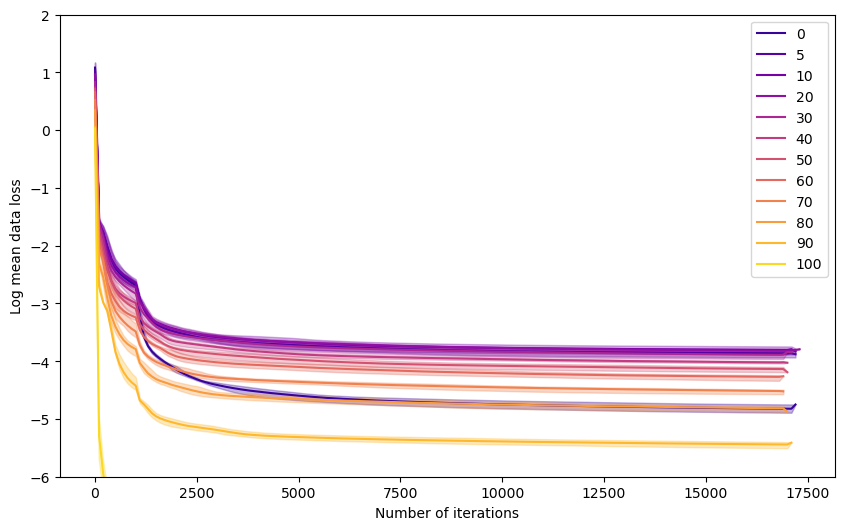

In [71]:
# loss_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_losses.npz"
# loaded_data = np.load(loss_file) # to load the arrays from the .npz file:

# data_losses_all = loaded_data['data_losses_all']
# eq_losses_all = loaded_data['eq_losses_all']
# val_losses_all = loaded_data['val_losses_all']
# losses_all = loaded_data['losses_all']

colors = sns.color_palette("coolwarm", 12)
fig, ax = plt.subplots(1, 1, figsize=(10,6))
iterations = list(range(0,losses_all[:,1:].shape[1]))
iterations = [i * 100 for i in iterations]
for i in range(losses_all.shape[0]//5):
# for i in range(11,13):
    mean_data_loss = np.nanmean(losses_all[i*5:i*5+5,1:],axis=0)
    upper_data_loss = np.nanmax(losses_all[i*5:i*5+5,1:],axis=0)
    lower_data_loss = np.nanmin(losses_all[i*5:i*5+5,1:],axis=0)
    ax.plot(iterations, np.log(mean_data_loss), linestyle='-', color=colors[i])
    ax.fill_between(iterations, np.log(lower_data_loss), np.log(upper_data_loss) ,alpha=0.3, color=colors[i])
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Log mean data loss')
ax.set_ylim([-6,2])
ax.legend(train_percent)
# # plt.xticks(rotation=45);
plt.show()

In [50]:
# test = eq_losses_all[:,1:10]
np.mean(test[0:5,:],axis=0)
# test[0:5,:]

array([1.20966624, 0.4132988 , 0.42241188, 0.51039742, 0.5633172 ,
       0.60882487, 0.64807312, 0.6643751 , 0.67898898])

In [8]:
# storing errors from model gamma and 5% training data

train_percent = ['5','10','20','30','40','50','60','70','80','90','100']
for i in range(len(train_percent)):
    for j in range(5):
        if train_percent[i] == '10':
            ckpt_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_run"+str(j+1)+".ckpt"
            array_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_run"+str(j+1)+".npz"
        else:
            ckpt_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma"+train_percent[i]+"_run"+str(j+1)+".ckpt"
            array_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma"+train_percent[i]+"_run"+str(j+1)+".npz"
        
        loaded_data = np.load(array_file) # to load the arrays from the .npz file:
        
        inputs_train=loaded_data['inputs_train']
        char_train=loaded_data['char_train']
        lb_train=loaded_data['lb_train']
        col_train=loaded_data['col_train']
        inputs_val=loaded_data['inputs_val']
        layers=loaded_data['layers']
        f_col=loaded_data['f_col']
        inputs_test=loaded_data['inputs_test']

        tf.reset_default_graph()
        if __name__ == "__main__":  
            model = PhysicsInformedNN(inputs_train, char_train, lb_train, col_train, inputs_val, layers, f_col, 0.1)
            model.saver.restore(model.sess, ckpt_file)
            print('model reloaded!')
            
            t_test = inputs_test[:,0:1]
            z_test = inputs_test[:,1:2]
            y_test = inputs_test[:,2:3]
            x_test = inputs_test[:,3:4]
            T_test = inputs_test[:,4:5]
            S_test = inputs_test[:,5:6] 
            u_test = inputs_test[:,6:7]
            v_test = inputs_test[:,7:8]
            w_test = inputs_test[:,8:9]
            p_test = inputs_test[:,9:10]
            rho_test = inputs_test[:,10:11]

            # model prediction
            u_pred, v_pred, w_pred, p_pred, rho_pred, T_pred, S_pred, Kx_pred, Ky_pred, Kz_pred = model.predict(t_test, z_test, y_test, x_test)

        # Relative error (from normalized quantities)
        error_T = np.sum(np.square((T_test - T_pred)))/np.sum(np.square((T_test)))
        error_S = np.sum(np.square((S_test - S_pred)))/np.sum(np.square((S_test)))
        error_u = np.sum(np.square((u_test - u_pred)))/np.sum(np.square((u_test)))
        error_v = np.sum(np.square((v_test - v_pred)))/np.sum(np.square((v_test)))
        error_w = np.sum(np.square((w_test - w_pred)))/np.sum(np.square((w_test)))
        error_p = np.sum(np.square((p_test - p_pred)))/np.sum(np.square((p_test)))
        error_rho = np.sum(np.square((rho_test - rho_pred)))/np.sum(np.square((rho_test)))

        if i==0 and j==0:
            rel_errors = np.array([float(train_percent[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            rel_errors = rel_errors[np.newaxis,:]
        else:
            throwaway = np.array([float(train_percent[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            throwaway = throwaway[np.newaxis,:]
            rel_errors = np.concatenate((rel_errors,throwaway),axis=0)
            
        # Correlation error
        error_u = r2_score(u_test, u_pred)
        error_v = r2_score(v_test, v_pred)
        error_w = r2_score(w_test, w_pred)
        error_p = r2_score(p_test, p_pred)
        error_rho = r2_score(rho_test, rho_pred)
        error_T = r2_score(T_test, T_pred)
        error_S = r2_score(S_test, S_pred)
        
        if i==0 and j==0:
            r2_errors = np.array([float(train_percent[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            r2_errors = r2_errors[np.newaxis,:]
        else:
            throwaway = np.array([float(train_percent[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            throwaway = throwaway[np.newaxis,:]
            r2_errors = np.concatenate((r2_errors,throwaway),axis=0)

# save errors
error_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_errors.npz"
np.savez(error_file, r2_errors=r2_errors, rel_errors=rel_errors)

r2_errors

INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma5_run1.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma5_run2.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma5_run3.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma5_run4.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma5_run5.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-complexity/latlo

array([[ 5.00000000e+00,  9.08770961e-01,  8.73934438e-01,
         4.56327933e-01,  9.98850241e-01,  9.99915696e-01,
         9.96787770e-01,  9.97133170e-01],
       [ 5.00000000e+00,  9.01118837e-01,  8.74278791e-01,
        -9.77703876e-01,  9.98739561e-01,  9.99816141e-01,
         9.80564098e-01,  9.97099442e-01],
       [ 5.00000000e+00,  8.77187744e-01,  8.50873863e-01,
        -1.30945034e-01,  9.98835660e-01,  9.99828206e-01,
         9.80680442e-01,  9.97683833e-01],
       [ 5.00000000e+00,  8.97032646e-01,  8.35996786e-01,
        -8.96230067e-01,  9.98846434e-01,  9.99896035e-01,
         9.96609699e-01,  9.96961901e-01],
       [ 5.00000000e+00,  8.93997765e-01,  8.82014659e-01,
        -2.45912510e-01,  9.98854543e-01,  9.99837406e-01,
         9.90094376e-01,  9.94404132e-01],
       [ 1.00000000e+01,  8.61208024e-01,  7.73065014e-01,
        -5.01287018e-02,  9.98183984e-01,  9.99899746e-01,
         9.97181920e-01,  9.93955989e-01],
       [ 1.00000000e+01,  8.756388

In [77]:
# storing errors from model gamma and 1% training data

train_percent = ['0','5','10','20','30','40','50','60','70','80','90','100']
for i in range(len(train_percent)):
    for j in range(5):
        ckpt_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma-1/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma"+train_percent[i]+"_run"+str(j+1)+".ckpt"
        array_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma-1/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma"+train_percent[i]+"_run"+str(j+1)+".npz"

        loaded_data = np.load(array_file) # to load the arrays from the .npz file:
        
        inputs_train=loaded_data['inputs_train']
        char_train=loaded_data['char_train']
        lb_train=loaded_data['lb_train']
        col_train=loaded_data['col_train']
        inputs_val=loaded_data['inputs_val']
        layers=loaded_data['layers']
        f_col=loaded_data['f_col']
        inputs_test=loaded_data['inputs_test']

        tf.reset_default_graph()
        if __name__ == "__main__":  
            model = PhysicsInformedNN(inputs_train, char_train, lb_train, col_train, inputs_val, layers, f_col, 0.1)
            model.saver.restore(model.sess, ckpt_file)
            print('model reloaded!')
            
            t_test = inputs_test[:,0:1]
            z_test = inputs_test[:,1:2]
            y_test = inputs_test[:,2:3]
            x_test = inputs_test[:,3:4]
            T_test = inputs_test[:,4:5]
            S_test = inputs_test[:,5:6] 
            u_test = inputs_test[:,6:7]
            v_test = inputs_test[:,7:8]
            w_test = inputs_test[:,8:9]
            p_test = inputs_test[:,9:10]
            rho_test = inputs_test[:,10:11]

            # model prediction
            u_pred, v_pred, w_pred, p_pred, rho_pred, T_pred, S_pred, Kx_pred, Ky_pred, Kz_pred = model.predict(t_test, z_test, y_test, x_test)

        # Relative error (from normalized quantities)
        error_T = np.sum(np.square((T_test - T_pred)))/np.sum(np.square((T_test)))
        error_S = np.sum(np.square((S_test - S_pred)))/np.sum(np.square((S_test)))
        error_u = np.sum(np.square((u_test - u_pred)))/np.sum(np.square((u_test)))
        error_v = np.sum(np.square((v_test - v_pred)))/np.sum(np.square((v_test)))
        error_w = np.sum(np.square((w_test - w_pred)))/np.sum(np.square((w_test)))
        error_p = np.sum(np.square((p_test - p_pred)))/np.sum(np.square((p_test)))
        error_rho = np.sum(np.square((rho_test - rho_pred)))/np.sum(np.square((rho_test)))

        if i==0 and j==0:
            rel_errors = np.array([float(train_percent[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            rel_errors = rel_errors[np.newaxis,:]
        else:
            throwaway = np.array([float(train_percent[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            throwaway = throwaway[np.newaxis,:]
            rel_errors = np.concatenate((rel_errors,throwaway),axis=0)
            
        # Correlation error
        error_u = r2_score(u_test, u_pred)
        error_v = r2_score(v_test, v_pred)
        error_w = r2_score(w_test, w_pred)
        error_p = r2_score(p_test, p_pred)
        error_rho = r2_score(rho_test, rho_pred)
        error_T = r2_score(T_test, T_pred)
        error_S = r2_score(S_test, S_pred)
        
        if i==0 and j==0:
            r2_errors = np.array([float(train_percent[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            r2_errors = r2_errors[np.newaxis,:]
        else:
            throwaway = np.array([float(train_percent[i]), error_u, error_v, error_w, error_p, error_rho, error_T, error_S])
            throwaway = throwaway[np.newaxis,:]
            r2_errors = np.concatenate((r2_errors,throwaway),axis=0)

# save errors
error_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma-1/latlon_k2037_j4070_i4070_gamma10_iter16000_errors.npz"
np.savez(error_file, r2_errors=r2_errors, rel_errors=rel_errors)

# r2_errors

INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma-1/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma0_run1.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma-1/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma0_run2.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma-1/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma0_run3.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma-1/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma0_run4.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma-1/latlon_k2037_j4070_i4070_gamma10_iter16000_layer20_gamma0_run5.ckpt
model reloaded!
INFO:tensorflow:Restoring parameters from /scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma-

In [72]:
error_file = "/scratch/gpfs/wc4720/SOCCOM/saved-models/model-gamma/latlon_k2037_j4070_i4070_gamma10_iter16000_errors.npz"
loaded_data = np.load(error_file) # to load the arrays from the .npz file:
        
r2_errors=loaded_data['r2_errors']
rel_errors=loaded_data['rel_errors']

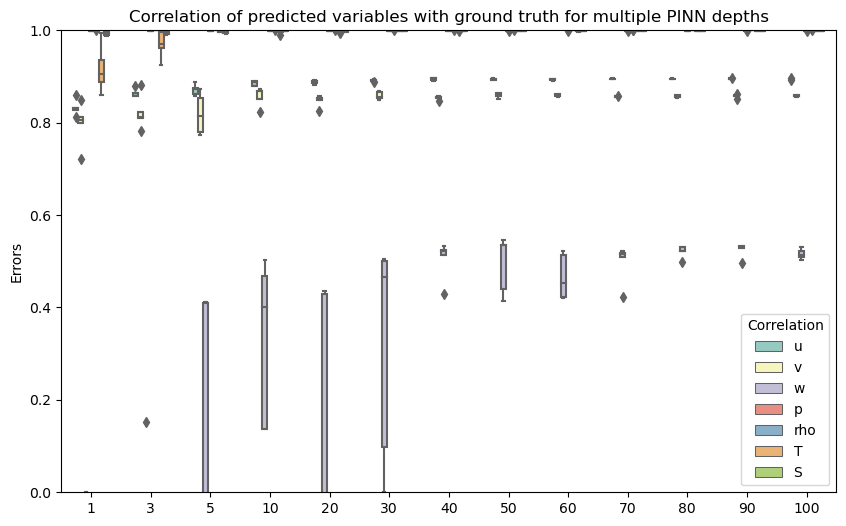

In [58]:
# Box plots

# labels = r2_errors[:,0].astype('int')
# errors = r2_errors[:,7]

# # Grouping data by labels
# grouped_data = {}
# for label, error in zip(labels, errors):
#     if label not in grouped_data:
#         grouped_data[label] = []
#     grouped_data[label].append(error)

# # Creating boxplot
# plt.figure(figsize=(7, 5))
# plt.boxplot(grouped_data.values(), labels=grouped_data.keys(), patch_artist=True)
# plt.xlabel('PINN training data %')
# plt.ylabel('correlation')
# # plt.grid(True)
# plt.show()

# Your data
labels =  r2_errors[:,0].astype('int')

# Creating a DataFrame
data = pd.DataFrame({
    'Label': np.tile(labels,7),  # Repeat labels to match each error type
    'Error Type': ['u']*len(labels) + ['v']*len(labels) + ['w']*len(labels) + ['p']*len(labels) + ['rho']*len(labels) + ['T']*len(labels) + ['S']*len(labels),
    'Error': np.concatenate((r2_errors[:,1], r2_errors[:,2], r2_errors[:,3], r2_errors[:,4], r2_errors[:,5], r2_errors[:,6], r2_errors[:,7])) #errors_type1 + errors_type2
})

# Creating grouped box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Label', y='Error', hue='Error Type', width=0.6, palette="Set3")
plt.xlabel('')
plt.ylim((0,1))
plt.ylabel('Errors')
plt.title('Correlation of predicted variables with ground truth for multiple PINN depths')
plt.legend(title='Correlation')
# plt.grid(True)
plt.show()

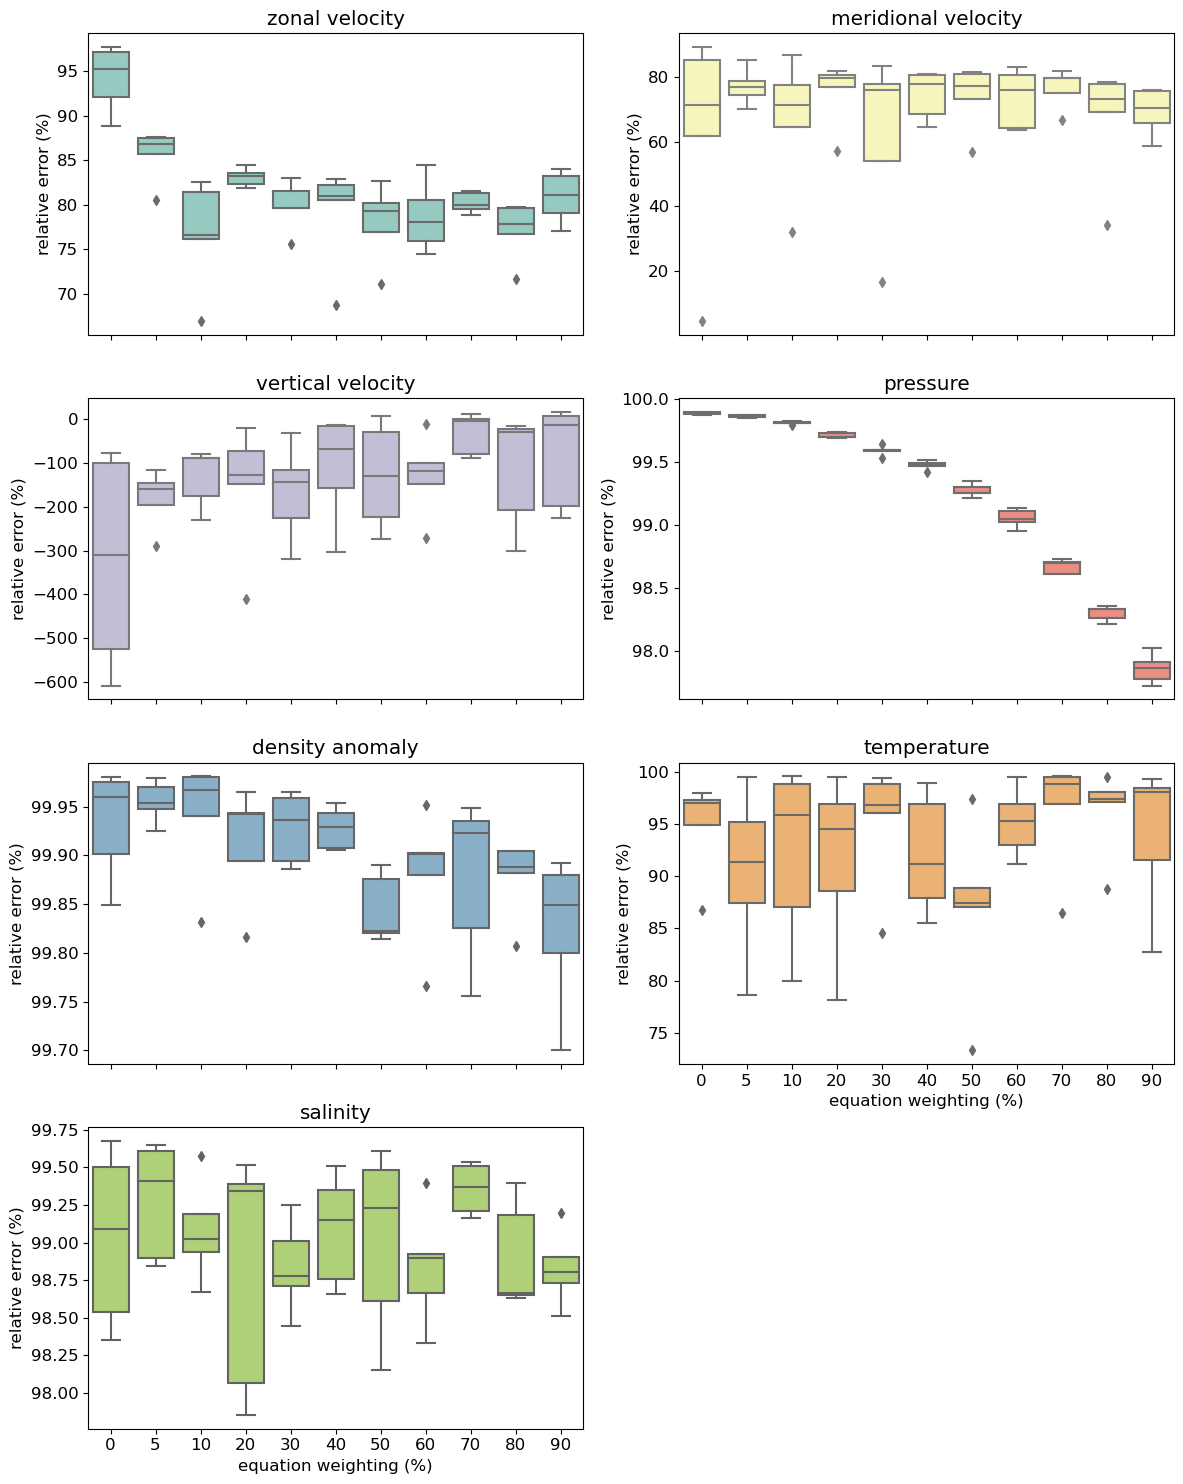

In [82]:
### TEXT FORMAT
# Create subplots for each error type

# Your data
labels =  r2_errors[:-5,0].astype('int')

# Creating a DataFrame
data = pd.DataFrame({
    'Label': np.tile(labels,7),  # Repeat labels to match each error type
    'Error Type': ['u']*len(labels) + ['v']*len(labels) + ['w']*len(labels) + ['p']*len(labels) + ['rho']*len(labels) + ['T']*len(labels) + ['S']*len(labels),
    'Error': np.concatenate((r2_errors[:-5,1]*100, r2_errors[:-5,2]*100, r2_errors[:-5,3]*100, r2_errors[:-5,4]*100, r2_errors[:-5,5]*100, r2_errors[:-5,6]*100, r2_errors[:-5,7]*100)) #errors_type1 + errors_type2
})

plt.rcParams.update({'font.size': 12})
plt.style.use('tableau-colorblind10')
fig, axes = plt.subplots(4, 2, figsize=(12, 15))#, sharex=True)  # 1 row, 2 columns

# Filter data for each error type
error_type1_data = data[data['Error Type'] == 'u']
error_type2_data = data[data['Error Type'] == 'v']
error_type3_data = data[data['Error Type'] == 'w']
error_type4_data = data[data['Error Type'] == 'p']
error_type5_data = data[data['Error Type'] == 'rho']
error_type6_data = data[data['Error Type'] == 'T']
error_type7_data = data[data['Error Type'] == 'S']

# axes[0,0].yaxis.set_major_formatter('{x:0<7.00001f}')

# Create box plots for each error type
sns.boxplot(data=error_type1_data, x='Label', y='Error', ax=axes[0,0], color=sns.color_palette('Set3')[0])
axes[0,0].set_title('zonal velocity')
axes[0,0].set_xlabel('')
axes[0,0].set_xticklabels([])
axes[0,0].set_ylabel('relative error (%)')

sns.boxplot(data=error_type2_data, x='Label', y='Error', ax=axes[0,1], color=sns.color_palette('Set3')[1])
axes[0,1].set_title('meridional velocity')
axes[0,1].set_xlabel('')
axes[0,1].set_xticklabels([])
axes[0,1].set_ylabel('relative error (%)')

sns.boxplot(data=error_type3_data, x='Label', y='Error', ax=axes[1,0], color=sns.color_palette('Set3')[2])
axes[1,0].set_title('vertical velocity')
axes[1,0].set_xlabel('')
axes[1,0].set_xticklabels([])
axes[1,0].set_ylabel('relative error (%)')

sns.boxplot(data=error_type4_data, x='Label', y='Error', ax=axes[1,1], color=sns.color_palette('Set3')[3])
axes[1,1].set_title('pressure')
axes[1,1].set_xlabel('')
axes[1,1].set_xticklabels([])
axes[1,1].set_ylabel('relative error (%)')

sns.boxplot(data=error_type5_data, x='Label', y='Error', ax=axes[2,0], color=sns.color_palette('Set3')[4])
axes[2,0].set_title('density anomaly')
axes[2,0].set_xlabel('')
axes[2,0].set_xticklabels([])
axes[2,0].set_ylabel('relative error (%)')

sns.boxplot(data=error_type6_data, x='Label', y='Error', ax=axes[2,1], color=sns.color_palette('Set3')[5])
axes[2,1].set_title('temperature')
axes[2,1].set_xlabel('equation weighting (%)')
axes[2,1].set_ylabel('relative error (%)')

sns.boxplot(data=error_type7_data, x='Label', y='Error', ax=axes[3,0], color=sns.color_palette('Set3')[6])
axes[3,0].set_title('salinity')
axes[3,0].set_xlabel('equation weighting (%)')
axes[3,0].set_ylabel('relative error (%)')

axes[3,1].axis('off')

plt.tight_layout()
plt.show()

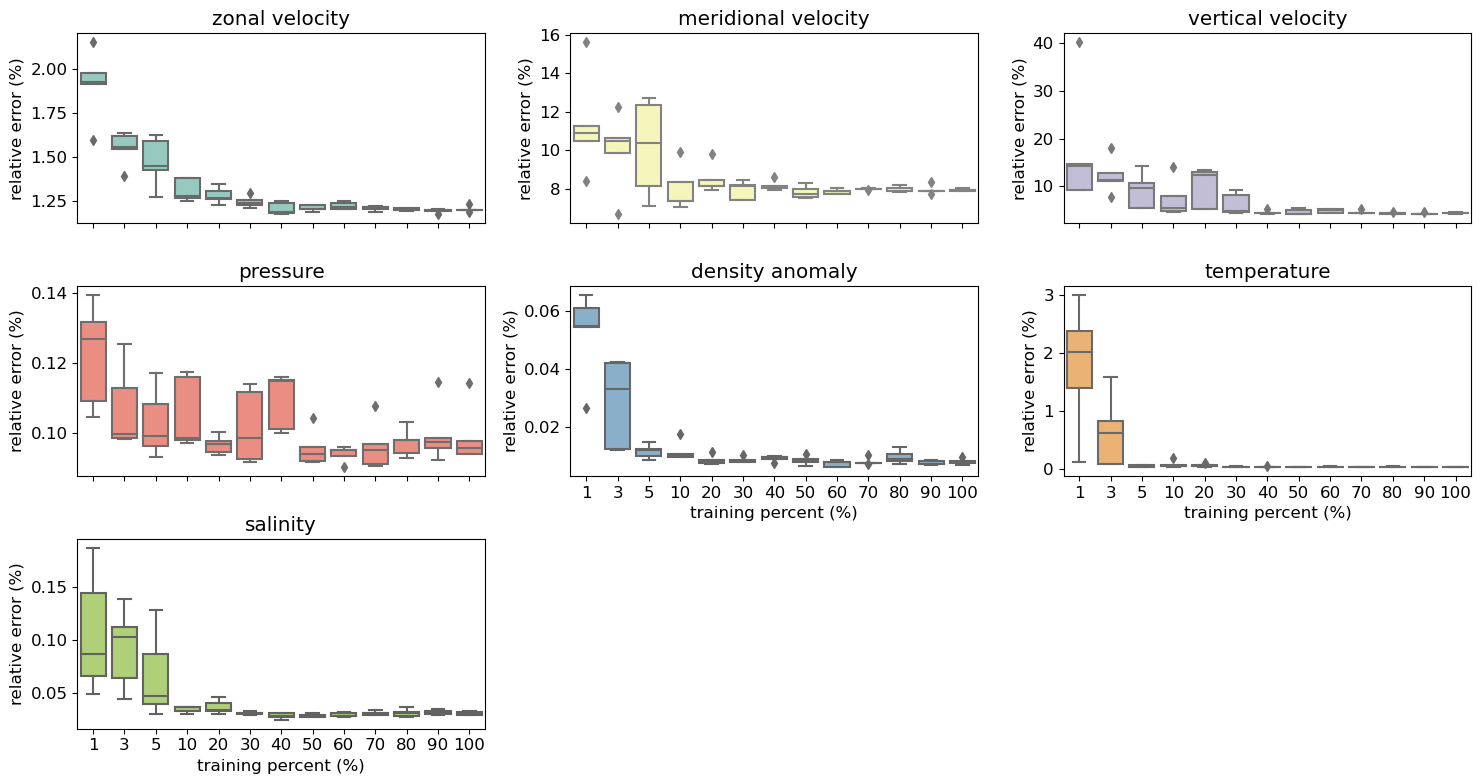

In [32]:
### SLIDE FORMAT
# Create subplots for each error type

# # Your data
# labels =  r2_errors[:,0].astype('int')

# # Creating a DataFrame
# data = pd.DataFrame({
#     'Label': np.tile(labels,7),  # Repeat labels to match each error type
#     'Error Type': ['u']*len(labels) + ['v']*len(labels) + ['w']*len(labels) + ['p']*len(labels) + ['rho']*len(labels) + ['T']*len(labels) + ['S']*len(labels),
#     'Error': np.concatenate((r2_errors[:,1], r2_errors[:,2], r2_errors[:,3], r2_errors[:,4], r2_errors[:,5], r2_errors[:,6], r2_errors[:,7])) #errors_type1 + errors_type2
# })

plt.rcParams.update({'font.size': 12})
plt.style.use('tableau-colorblind10')
fig, axes = plt.subplots(3, 3, figsize=(15, 8))#, sharex=True)  # 1 row, 2 columns

# # Filter data for each error type
# error_type1_data = data[data['Error Type'] == 'u']
# error_type2_data = data[data['Error Type'] == 'v']
# error_type3_data = data[data['Error Type'] == 'w']
# error_type4_data = data[data['Error Type'] == 'p']
# error_type5_data = data[data['Error Type'] == 'rho']
# error_type6_data = data[data['Error Type'] == 'T']
# error_type7_data = data[data['Error Type'] == 'S']

# axes[0,0].yaxis.set_major_formatter('{x:0<7.00001f}')

# Create box plots for each error type
sns.boxplot(data=error_type1_data, x='Label', y='Error', ax=axes[0,0], color=sns.color_palette('Set3')[0])
axes[0,0].set_title('zonal velocity')
axes[0,0].set_xlabel('')
axes[0,0].set_xticklabels([])
axes[0,0].set_ylabel('relative error (%)')

sns.boxplot(data=error_type2_data, x='Label', y='Error', ax=axes[0,1], color=sns.color_palette('Set3')[1])
axes[0,1].set_title('meridional velocity')
axes[0,1].set_xlabel('')
axes[0,1].set_xticklabels([])
axes[0,1].set_ylabel('relative error (%)')

sns.boxplot(data=error_type3_data, x='Label', y='Error', ax=axes[0,2], color=sns.color_palette('Set3')[2])
axes[0,2].set_title('vertical velocity')
axes[0,2].set_xlabel('')
axes[0,2].set_xticklabels([])
axes[0,2].set_ylabel('relative error (%)')

sns.boxplot(data=error_type4_data, x='Label', y='Error', ax=axes[1,0], color=sns.color_palette('Set3')[3])
axes[1,0].set_title('pressure')
axes[1,0].set_xlabel('')
axes[1,0].set_xticklabels([])
axes[1,0].set_ylabel('relative error (%)')

sns.boxplot(data=error_type5_data, x='Label', y='Error', ax=axes[1,1], color=sns.color_palette('Set3')[4])
axes[1,1].set_title('density anomaly')
axes[1,1].set_xlabel('training percent (%)')
axes[1,1].set_ylabel('relative error (%)')

sns.boxplot(data=error_type6_data, x='Label', y='Error', ax=axes[1,2], color=sns.color_palette('Set3')[5])
axes[1,2].set_title('temperature')
axes[1,2].set_xlabel('training percent (%)')
axes[1,2].set_ylabel('relative error (%)')

sns.boxplot(data=error_type7_data, x='Label', y='Error', ax=axes[2,0], color=sns.color_palette('Set3')[6])
axes[2,0].set_title('salinity')
axes[2,0].set_xlabel('training percent (%)')
axes[2,0].set_ylabel('relative error (%)')

axes[2,1].axis('off')
axes[2,2].axis('off')

plt.tight_layout()
plt.show()

In [92]:
# # PUT THE VELOCITIES INTO A NEW XARRAY
# the Navier stokes components only work if the collocation points are also the validation points!!!!!!

subset_template = ds.THETA.isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)).where(ds.maskC).rename('template')
T_pred = (T_pred+1)*char_train[4] + lb_train[4]
S_pred = (S_pred+1)*char_train[5] + lb_train[5]
UVEL_pred = (u_pred+1)*char_train[6] + lb_train[6]
VVEL_pred = (v_pred+1)*char_train[7] + lb_train[7]
WVELMASS_pred = (w_pred+1)*char_train[8] + lb_train[8]
P_pred = (p_pred+1)*char_train[9] + lb_train[9]
RHO_pred = (rho_pred+1)*char_train[10] + lb_train[10]

# reshaping back to 4d array
new_size = (np.unique(coords_test[:,0]).size,np.unique(coords_test[:,1]).size,np.unique(coords_test[:,2]).size,np.unique(coords_test[:,3]).size) # size of the original training domain

arrays_to_change = [UVEL_pred, VVEL_pred, WVELMASS_pred, P_pred, RHO_pred,T_pred, S_pred]#, Kx_pred, Ky_pred, Kz_pred] # no iteration data
for i in range(len(arrays_to_change)):
    arrays_to_change[i]= arrays_to_change[i].reshape(new_size)

# putting the predicted velocities into array to match the size of the model velocities
size_offset = np.array(subset_template.values.squeeze().shape) - np.array(arrays_to_change[0].shape)
# 'pad' the array with 0s to get it to be the same shape
# NOTE you have to change this if you mess with when the training data and testing data is

# these do not have iteration data
for i in range(len(arrays_to_change)):
    array_padding = ((size_offset[0], 0), (0, size_offset[1]), (0, size_offset[2]), (0, size_offset[3]))
    arrays_to_change[i] = np.lib.pad(arrays_to_change[i], array_padding, 'constant', constant_values=(np.nan))
    
# ds_model is a new xarray that contains both predicted velocities and original velocities

tags = ['UVEL_pred', 'VVEL_pred', 'WVELMASS_pred', 'P_pred', 'RHO_pred','T_pred','S_pred']#,'Kx_pred','Ky_pred','Kz_pred']

ds_model = subset_template
for i in range(len(tags)):
    ds_model[tags[i]] = (('time','k','j', 'i'), arrays_to_change[i])
    ds_model[tags[i]] = ds_model[tags[i]].where(ds.maskC.isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)))

ds_model = xr.merge([ds_model, ds.THETA.where(ds.maskC).isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)), ds.SALT.where(ds.maskC).isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)), ds.EVEL.where(ds.maskC).isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)),ds.where(ds.maskC).NVEL.isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)),ds.where(ds.maskC).WVELMASS_interp.isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)),ds.where(ds.maskC).PHI.isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind)), ds.RHOAnoma.where(ds.maskC).isel(k=slice(*k_ind),j=slice(*j_ind),i=slice(*i_ind))],compat='override')
ds_model = ds_model.reset_coords(tags) # move from coordinate to variable

# # set the differences into the output dataset 
ds_model['THETA_diff'] = ds_model.THETA - ds_model.T_pred
ds_model['SALT_diff'] = ds_model.SALT - ds_model.S_pred
ds_model['UVEL_diff'] = ds_model.EVEL - ds_model.UVEL_pred
ds_model['VVEL_diff'] = ds_model.NVEL - ds_model.VVEL_pred 
ds_model['WVELMASS_diff'] = ds_model.WVELMASS_interp - ds_model.WVELMASS_pred 
ds_model['P_diff'] = ds_model.PHI - ds_model.P_pred
ds_model['RHO_diff'] = ds_model.RHOAnoma - ds_model.RHO_pred 
ds_model['THETA_snr'] = ds_model.THETA.std(dim='time').load()/ds_model.THETA_diff.std(dim='time').load()
ds_model['SALT_snr'] = ds_model.SALT.std(dim='time').load()/ds_model.SALT_diff.std(dim='time').load()
ds_model['UVEL_snr'] = ds_model.EVEL.std(dim='time').load()/ds_model.UVEL_diff.std(dim='time').load()
ds_model['VVEL_snr'] = ds_model.NVEL.std(dim='time').load()/ds_model.VVEL_diff.std(dim='time').load()
ds_model['WVELMASS_snr'] = ds_model.WVELMASS_interp.std(dim='time').load()/ds_model.WVELMASS_diff.std(dim='time').load()
ds_model['P_snr'] = ds_model.PHI.std(dim='time').load()/ds_model.P_diff.std(dim='time').load()
ds_model['RHO_snr'] = ds_model.RHOAnoma.std(dim='time').load()/ds_model.RHO_diff.std(dim='time').load()

print('done with this section!')

done with this section!


In [79]:
### PLOTTING FUNCTIONS

plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.constrained_layout.use'] = False

def make_a_cube(ds_model, output_type):
    # plot a 3d cube plot of the prediction or training data
    # output type ranges from 0 to 4 for EVEL (0), NVEL (1), WVEL (2), PHIHYD (3), or RHO (4)
    # t_or_p can be training (0) or prediction (1)
    # ex: make_a_cube(ds_model, 3, 0)

    tags = [['THETA','SALT','EVEL', 'NVEL','WVELMASS_interp','PHI','RHOAnoma','DIFFKR'],
            ['T_pred','S_pred','UVEL_pred','VVEL_pred','WVELMASS_pred','P_pred','RHO_pred','Kz_pred'],
           ['THETA_diff','SALT_diff','UVEL_diff','VVEL_diff','WVELMASS_diff','P_diff','RHO_diff','Kz_diff']]

    levels=np.linspace(min(ds_model[tags[0][output_type]].min(),ds_model[tags[1][output_type]].min()).values, max(ds_model[tags[0][output_type]].max(),ds_model[tags[1][output_type]].max()), 20)

    seismic_nanmasked = plt.get_cmap('RdYlBu_r').copy()
    seismic_nanmasked.set_bad('white')

    # Create a figure with 3D ax
    gridspec = {'width_ratios': [1, 1, 1.15]}
    fig, axs = plt.subplots(1, 3, figsize=(30,8), subplot_kw={'projection': '3d'},gridspec_kw=gridspec)

    # #Set limits of the plot from coord limits
    xmin, xmax = ds_model.longitude.min(), ds_model.longitude.max()
    ymin, ymax = ds_model.latitude.min(), ds_model.latitude.max()
    zmin, zmax = ds.Z.isel(k=k_ind[1]-1), ds.Z.isel(k=k_ind[0])
    for ax in axs:
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])
        # Plot edges
        edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
        ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
        ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
        ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
        ax.plot([xmin, xmin], [ymin, ymax], zmax, **edges_kw)
        ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
        ax.plot([xmin, xmax], [ymax, ymax], zmax, **edges_kw)
        ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
        ax.plot([xmax, xmax], [ymax, ymax], [zmin, zmax], **edges_kw)
        ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
        ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
        # Set labels and zticks
        # ax.set(xlabel='longitude', ylabel='latitude',zlabel='depth')#, zlabel='depth')
        ax.set_xlabel('\n' + 'longitude', linespacing=4)
        ax.set_ylabel('\n' + 'latitude', linespacing=4)
        ax.set_zlabel('\n' + 'depth', linespacing=6)
        ax.tick_params(pad=7)
        ax.tick_params(axis='z', pad=15)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.zaxis.set_major_locator(plt.MaxNLocator(5))
        # ax.tick_params(axis='x', rotation=-15)

    # TRAINING DATA
    if output_type < 7:
        # XY plot
        axs[0].contourf(ds_model.longitude.values, ds_model.latitude.values, ds_model[tags[0][output_type]].isel(k=0,time=0).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)
        
        ## XZ plot
        axs[0].contourf(np.tile(ds_model.longitude,(k_ind[1]-k_ind[0],1)), ds_model[tags[0][output_type]].isel(j=0,time=0).values, np.transpose(np.tile(ds_model.Z,(ds_model.i.max().values-ds_model.i.min().values+1,1))), zdir='y', offset=ymin,cmap=seismic_nanmasked, levels=levels)

        ## YZ plot
        axs[0].contourf(ds_model[tags[0][output_type]].isel(i=-1,time=0).values, np.tile(ds_model.latitude,(k_ind[1]-k_ind[0],1)), np.transpose(np.tile(ds_model.Z,(ds_model.j.max().values-ds_model.j.min().values+1,1))), zdir='x', offset=xmax,cmap=seismic_nanmasked, levels=levels)

    elif output_type == 7:
        
        levels=np.linspace(ds_model[tags[0][output_type]].min(), ds_model[tags[0][output_type]].max(), 20)
        
        # XY plot
        axs[0].contourf(ds_model.XC.isel(tile=0).values, ds_model.YC.isel(tile=0).values, ds_model[tags[0][output_type]].isel(k=0, tile=0).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)

        ## XZ plot
        axs[0].contourf(np.tile(ds_model.XC.isel(j=0,tile=0),(k_ind[1]-k_ind[0],1)), ds_model[tags[0][output_type]].isel(j=0,tile=0).values, np.transpose(np.tile(ds_model.Z,(ds_model.i.max().values-ds_model.i.min().values+1,1))), zdir='y', offset=ymin,cmap=seismic_nanmasked, levels=levels)

        ## YZ plot
        axs[0].contourf(ds_model[tags[0][output_type]].isel(i=-1,tile=0).values, np.tile(ds_model.YC.isel(i=-1,tile=0),(k_ind[1]-k_ind[0],1)), np.transpose(np.tile(ds_model.Z,(ds_model.j.max().values-ds_model.j.min().values+1,1))), zdir='x', offset=xmax,cmap=seismic_nanmasked, levels=levels)

        levels=np.linspace(min(ds_model[tags[0][output_type]].min(),ds_model[tags[1][output_type]].min()).values, max(ds_model[tags[0][output_type]].max(),ds_model[tags[1][output_type]].max()), 20)
        
    # PREDICTION DATA
    # XY plot
    axs[1].contourf(ds_model.longitude.values, ds_model.latitude.values, ds_model[tags[1][output_type]].isel(k=0,time=0).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)

    ## XZ plot
    axs[1].contourf(np.tile(ds_model.longitude,(k_ind[1]-k_ind[0],1)), ds_model[tags[1][output_type]].isel(j=0,time=0).values, np.transpose(np.tile(ds_model.Z,(ds_model.i.max().values-ds_model.i.min().values+1,1))), zdir='y', offset=ymin,cmap=seismic_nanmasked, levels=levels)

    ## YZ plot
    C = axs[1].contourf(ds_model[tags[1][output_type]].isel(i=-1,time=0).values, np.tile(ds_model.latitude,(k_ind[1]-k_ind[0],1)), np.transpose(np.tile(ds_model.Z,(ds_model.j.max().values-ds_model.j.min().values+1,1))), zdir='x', offset=xmax,cmap=seismic_nanmasked, levels=levels)

    # DIFFERENCE DATA

    levels=np.linspace(ds_model[tags[2][output_type]].min().values, ds_model[tags[2][output_type]].max(), 20)
    seismic_nanmasked = plt.get_cmap('RdBu_r').copy()
    # norm = colors.TwoSlopeNorm(vmin=ds_model[tags[2][output_type]].min().values, vcenter=0, vmax=ds_model[tags[2][output_type]].max())
    seismic_nanmasked.set_bad('white')

    # XY plot
    axs[2].contourf(ds_model.longitude.values, ds_model.latitude.values, ds_model[tags[2][output_type]].isel(k=0,time=0).values, zdir='z', offset=zmax, cmap=seismic_nanmasked, levels=levels)#, norm=norm)

    ## XZ plot
    axs[2].contourf(np.tile(ds_model.longitude,(k_ind[1]-k_ind[0],1)), ds_model[tags[2][output_type]].isel(j=0,time=0).values, np.transpose(np.tile(ds_model.Z,(ds_model.i.max().values-ds_model.i.min().values+1,1))), zdir='y', offset=ymin, cmap=seismic_nanmasked, levels=levels)#, norm=norm)

    ## YZ plot
    D = axs[2].contourf(ds_model[tags[2][output_type]].isel(i=-1,time=0).values, np.tile(ds_model.latitude,(k_ind[1]-k_ind[0],1)), np.transpose(np.tile(ds_model.Z,(ds_model.j.max().values-ds_model.j.min().values+1,1))), zdir='x', offset=xmax, cmap=seismic_nanmasked, levels=levels)#, norm=norm)

#     # Colorbar
    cbar = fig.colorbar(C, ax=axs[0:2], pad=0.1, label=tags[0][output_type],fraction=0.018)#, orientation='horizontal')
    fig.colorbar(D, ax=axs[2],pad=0.2, label=tags[2][output_type],fraction=0.035)

    axs[0].set_title("True "+tags[0][output_type])
    axs[1].set_title("Predicted "+tags[0][output_type])
    axs[2].set_title("True - predicted "+tags[0][output_type])
    
    # plt.tight_layout()
    plt.show()

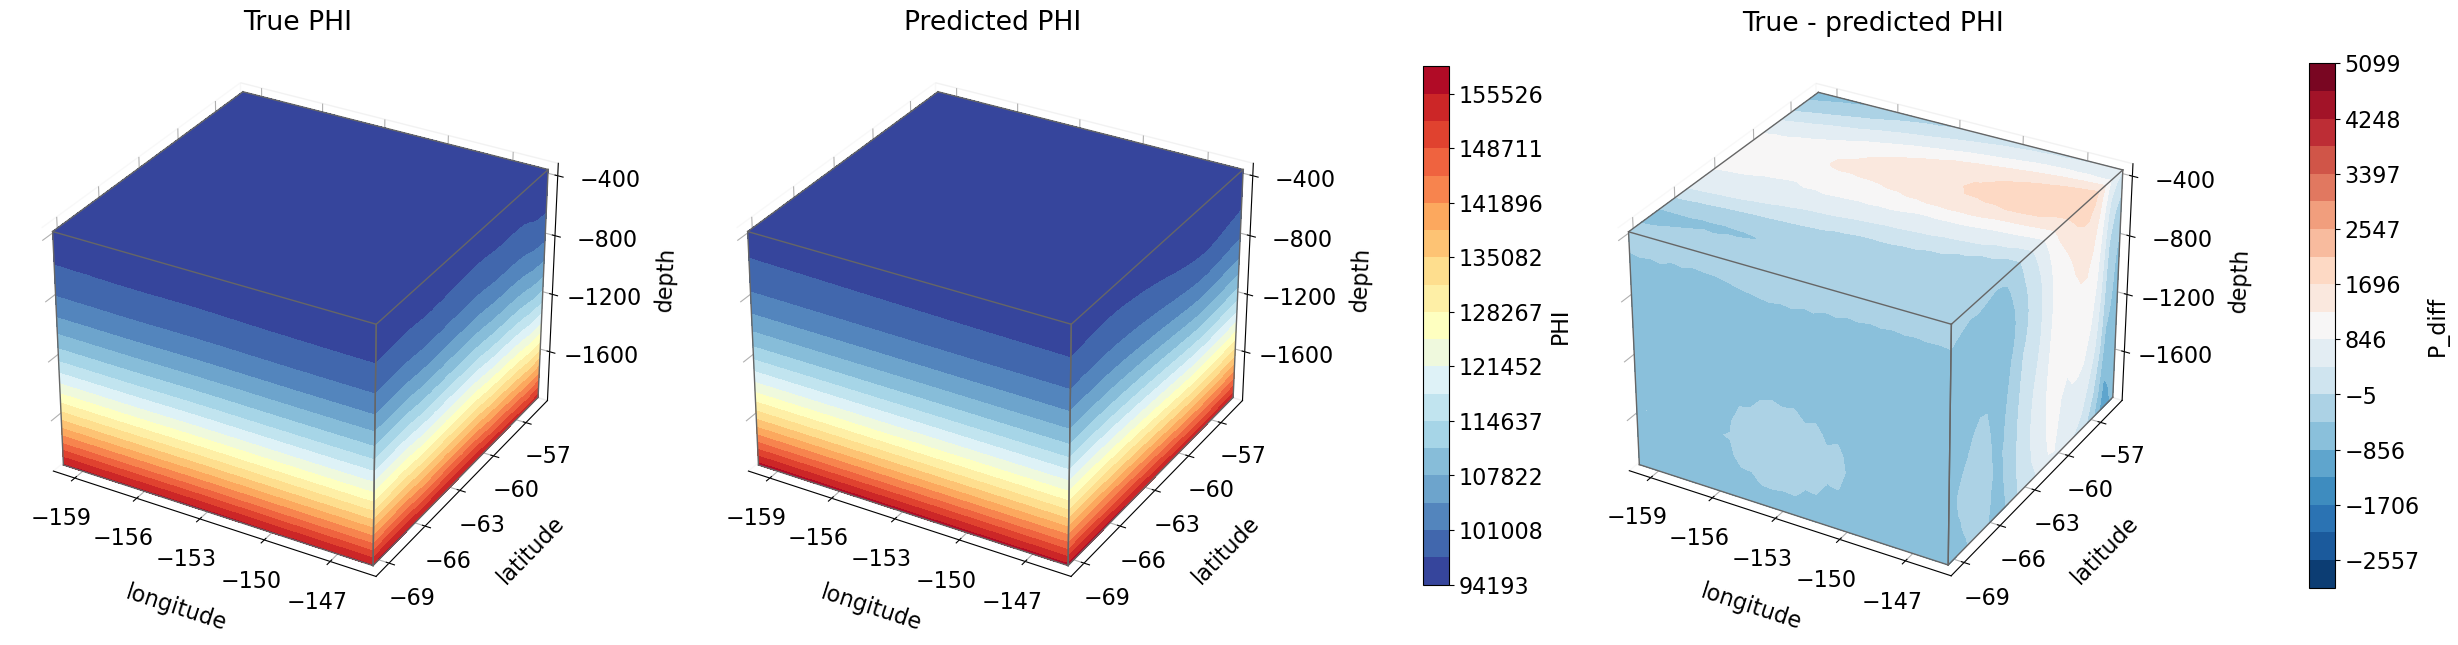

In [99]:
make_a_cube(ds_model,5)

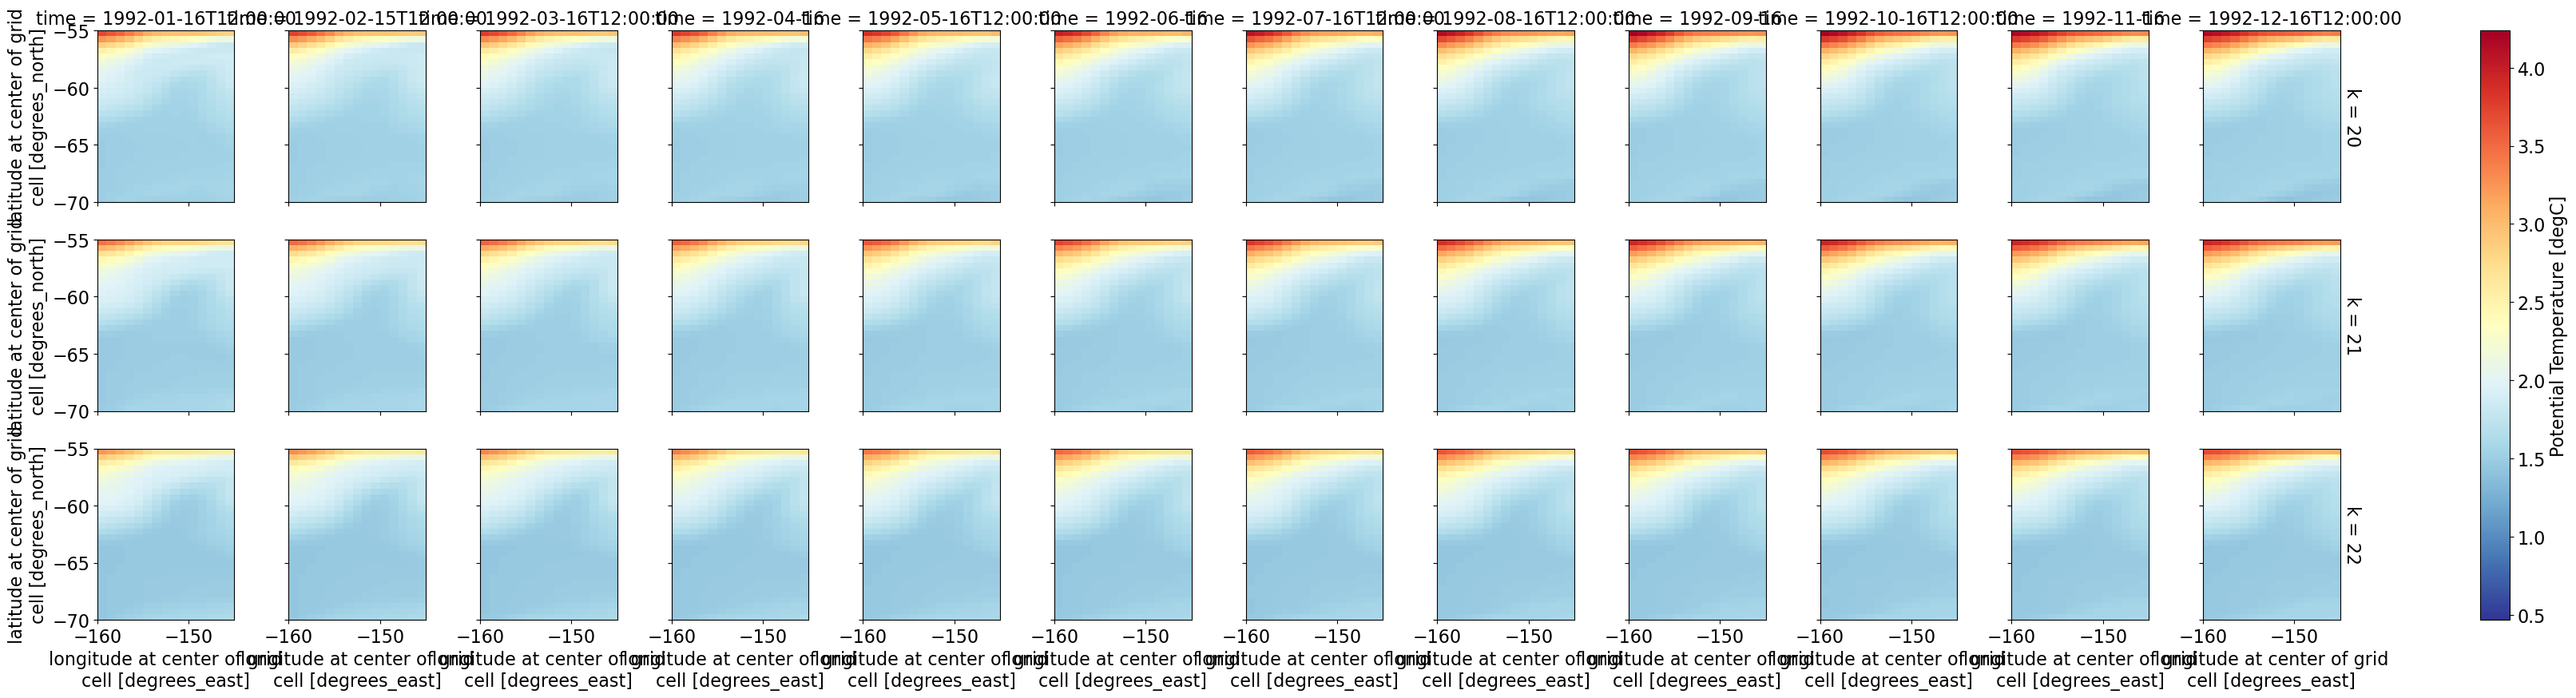

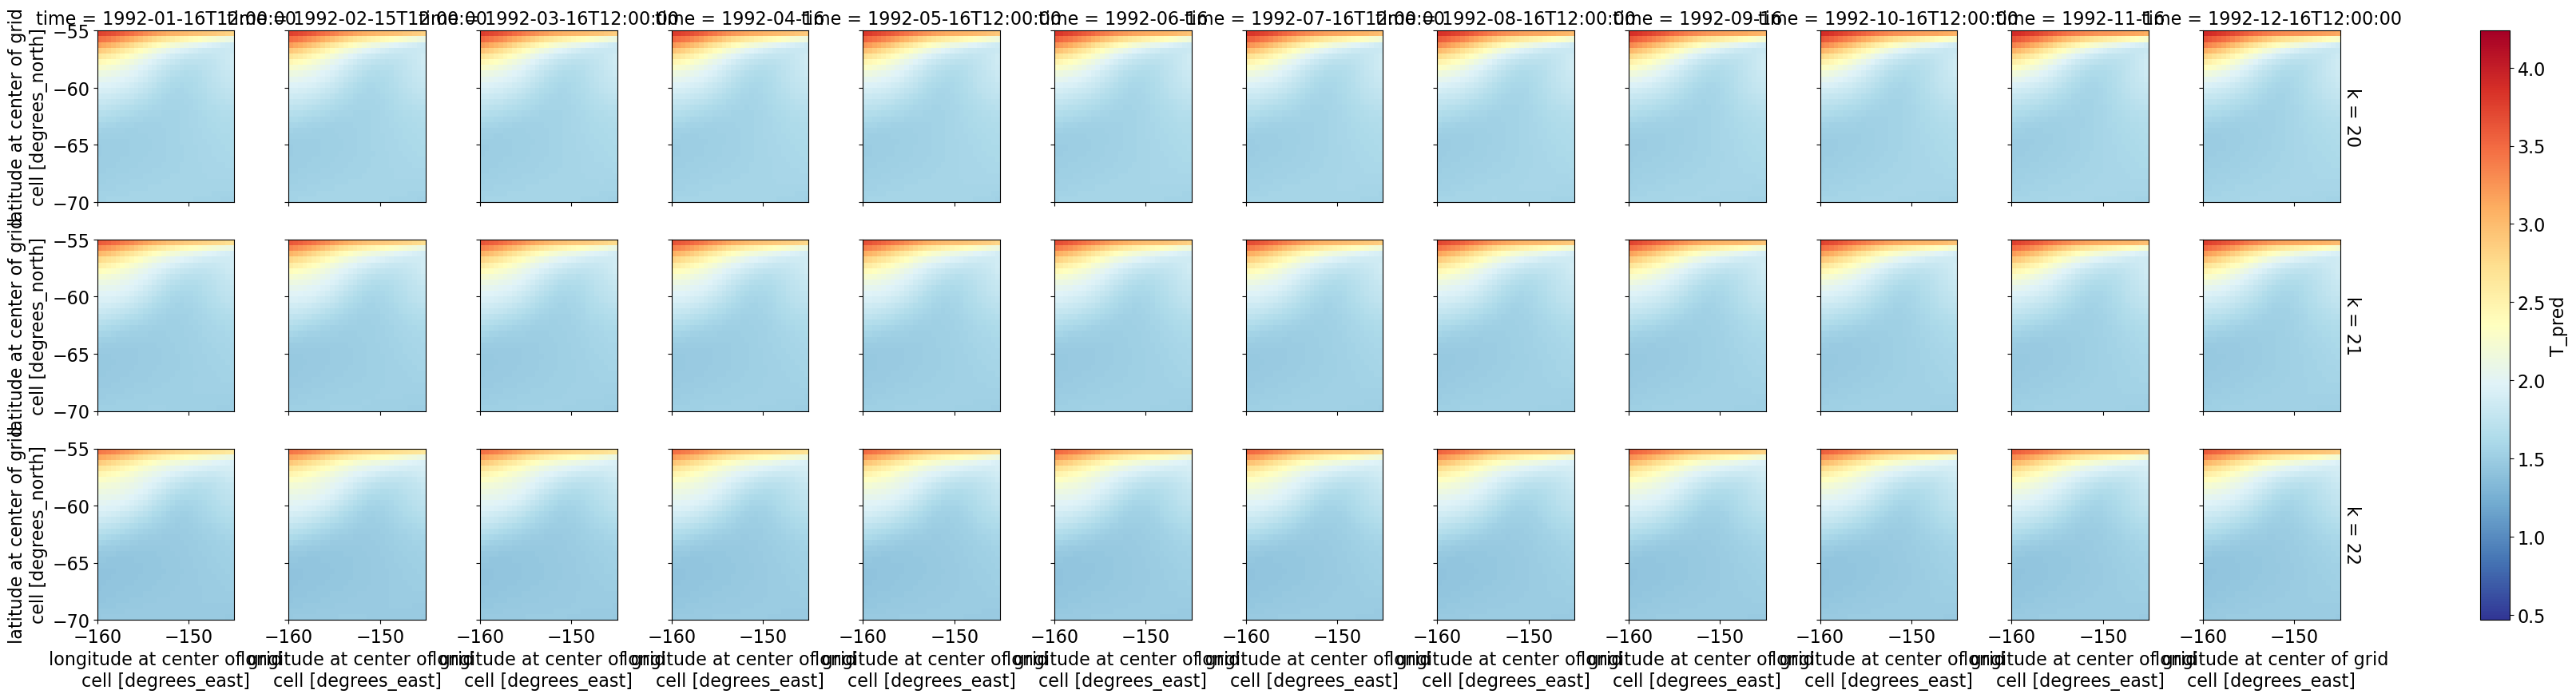

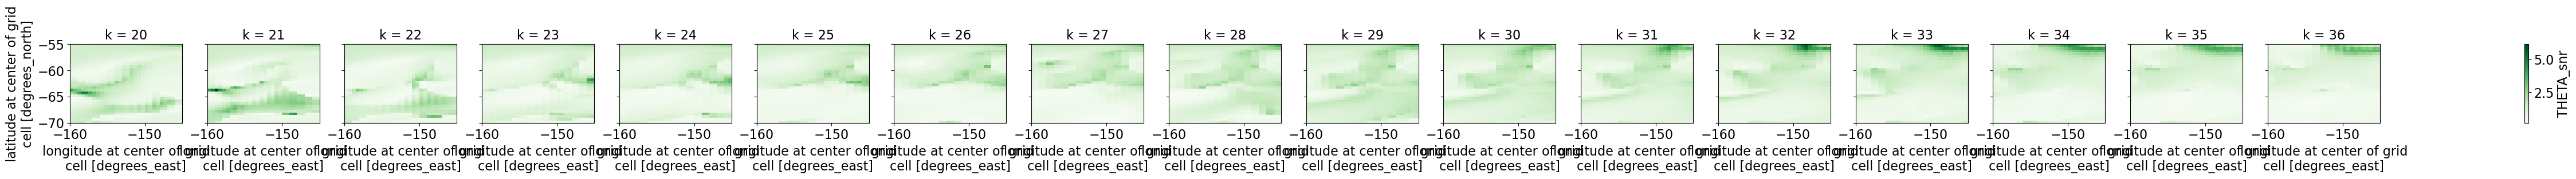

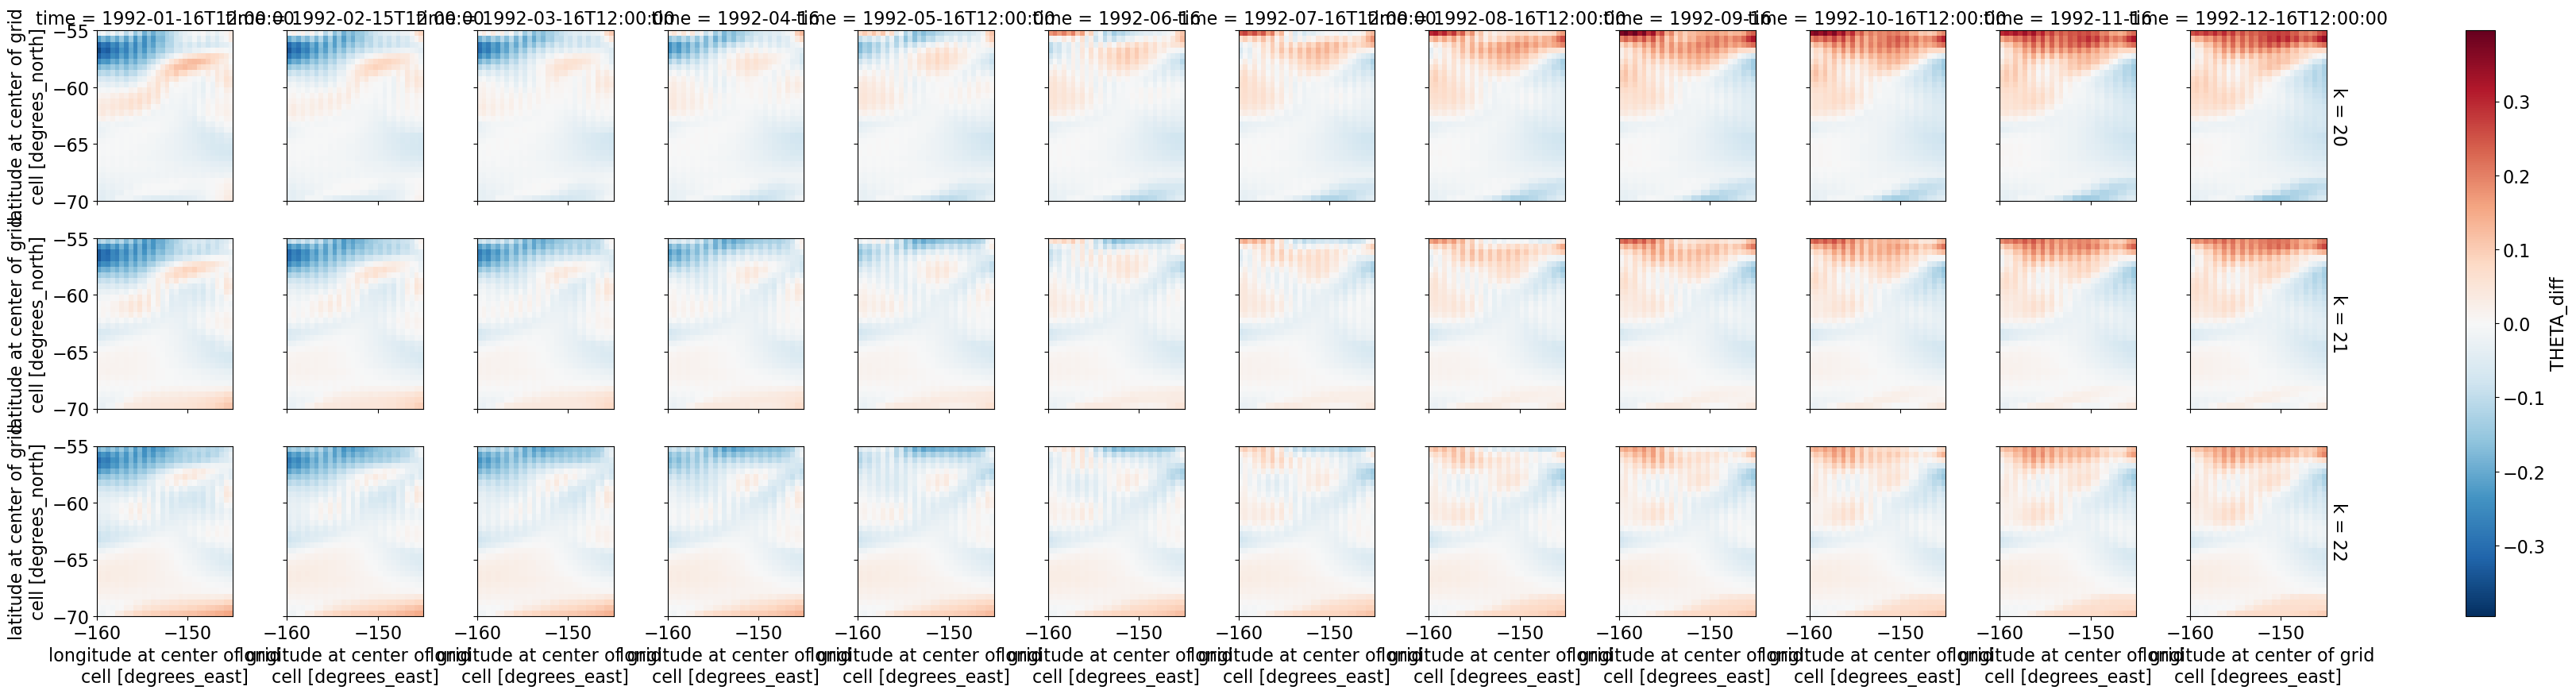

In [34]:
# make a mega plot of 4d data of zonal velocity

tags = [['THETA','SALT','EVEL', 'NVEL','WVELMASS_interp','PHI','RHOAnoma'],
        ['T_pred','S_pred','UVEL_pred','VVEL_pred','WVELMASS_pred','P_pred','RHO_pred'],
        ['THETA_diff','SALT_diff','UVEL_diff','VVEL_diff','WVELMASS_diff','P_diff','RHO_diff'],
       ['THETA_snr','SALT_snr','UVEL_snr','VVEL_snr','WVELMASS_snr','P_snr','RHO_snr']]

output_type = 0
tag_true = tags[0][output_type]
tag_pred = tags[1][output_type]
tag_diff = tags[2][output_type]
tag_snr = tags[3][output_type]

# chosen_depth=4
# # # each row of plots is a depth, each column is a time
vmin = min(ds_model[tag_true].min(),ds_model[tag_pred].min()).values
vmax = max(ds_model[tag_true].max(),ds_model[tag_pred].max()).values
# ds_model[tag_true].isel(time=slice(*time_ind),k=chosen_depth-k_ind[0]).plot(x='longitude', y='latitude', col='time', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
ds_model[tag_true].isel(time=slice(*time_ind),k=slice(0,3)).plot(x='longitude', y='latitude', col='time', row='k',cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
# ds_model[tag_pred].isel(time=slice(*time_ind),k=chosen_depth-k_ind[0]).plot(x='longitude', y='latitude', col='time', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
ds_model[tag_pred].isel(time=slice(*time_ind),k=slice(0,3)).plot(x='longitude', y='latitude', col='time', row='k', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
ds_model[tag_snr].plot(x='longitude', y='latitude', col='k',cmap='Greens')
# ds_model[tag_diff].isel(time=slice(*time_ind),k=chosen_depth-k_ind[0]).plot(x='longitude', y='latitude', col='time')
ds_model[tag_diff].isel(time=slice(*time_ind),k=slice(0,3)).plot(x='longitude', y='latitude', col='time', row='k')
plt.show()

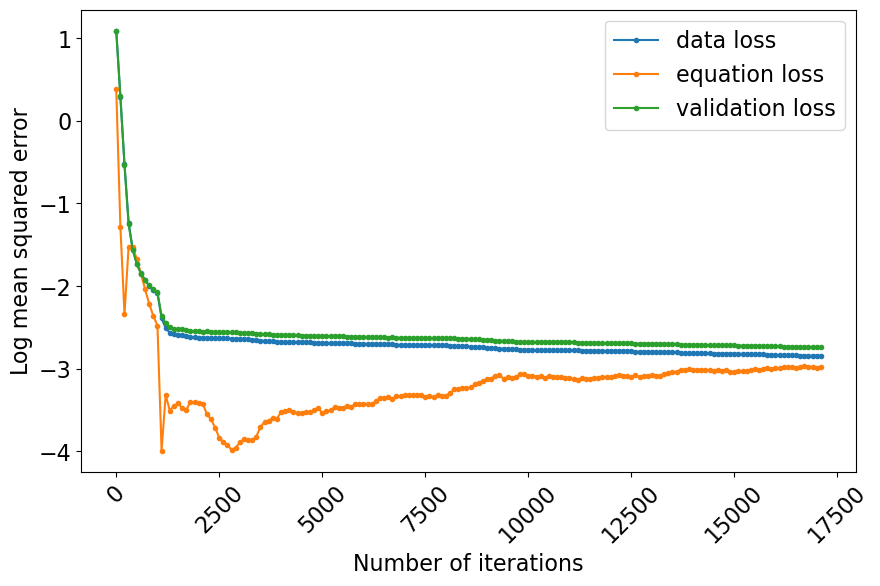

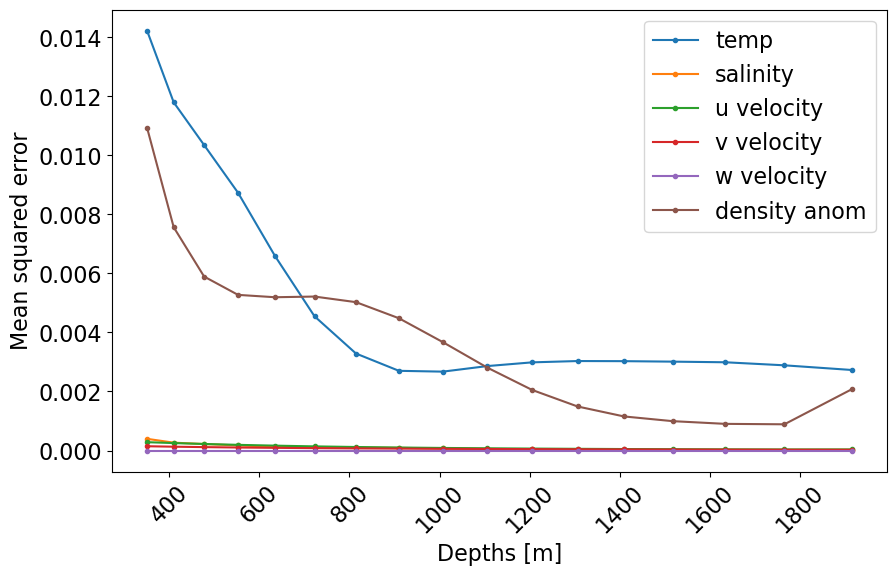

In [97]:
# ######## Losses after each iteration #######################
# ########           ########### 
# fig, ax = plt.subplots(1, 1, figsize=(5,3))
# iterations = list(range(0,len(data_losses)))
# ax.scatter(iterations, data_losses, s = 0.5)
# ax.set_xlabel('Number of iterations')
# ax.set_ylabel('Mean squared error')
# plt.xticks(rotation=45);

# fig, ax = plt.subplots(1, 1, figsize=(5,3))
# # iterations = list(range(0,nIter,10))
# iterations = list(range(0,len(eq_losses)))
# ax.scatter(iterations, eq_losses, s = 0.5)
# ax.set_xlabel('Number of iterations')
# ax.set_ylabel('Mean squared error')
# # ax.set_ylim([0,1])
# plt.xticks(rotation=45);

# #ax.set_aspect('equal', 'box')

######## Losses after each iteration #######################
########           ########### 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
iterations = list(range(0,len(data_losses)))
iterations = [i * 100 for i in iterations]
ax.plot(iterations, np.log(data_losses), marker='.',linestyle='-')
ax.plot(iterations, np.log(eq_losses), marker='.',linestyle='-')
ax.plot(iterations, np.log(val_losses), marker='.',linestyle='-')
# ax.plot(iterations, np.log(temp_losses), marker='.',linestyle='-')
# ax.plot(iterations, np.log(salt_losses), marker='.',linestyle='-')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Log mean squared error')
ax.legend(['data loss','equation loss','validation loss','temp loss','salt loss'])
plt.xticks(rotation=45);
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10,6))
depths = -1*ds.Z.isel(k=slice(*k_ind))
# tags = [['EVEL','NVEL','WVELMASS_interp','PHIHYD','RHOAnoma'],
#         ['UVEL_diff','VVEL_diff','WVELMASS_diff','P_diff','RHO_diff']]
tags = [['THETA','SALT','EVEL','NVEL','WVELMASS_interp','RHOAnoma'],#,'PHIHYD'],
    ['THETA_diff','SALT_diff','UVEL_diff','VVEL_diff','WVELMASS_diff','RHO_diff']]#,'P_diff']]
for i in range(len(tags[1])): 
    throwaway = ds_model[tags[1][i]]#/ds_model[tags[0][i]] # diff/actual
    throwaway = throwaway*throwaway
    # throwaway = throwaway/ds_model[tags[0][i]] # RMPSE as percentage
    throwaway = throwaway.mean(['i','j','time'])
    ax.plot(depths, throwaway, marker='.',linestyle='-')
# ax.plot(depths, ds_model['P_diff'].mean(['i','j','time']),marker='.',linestyle='-')
# ax.plot(depths, ds_model['RHO_diff'].mean(['i','j','time']),marker='.',linestyle='-')
ax.set_xlabel('Depths [m]')
ax.set_ylabel('Mean squared error')
ax.legend(['temp','salinity','u velocity','v velocity','w velocity','density anom','pressure'])
plt.xticks(rotation=45);
plt.show()